# Taxi demand prediction in New York City


<img src='new_york.gif'>

In [1]:
#Importing Libraries
import dask.dataframe as dd #similar to pandas
import pandas as pd #pandas to create small dataframes
import numpy as np #Do aritmetic operations on arrays
import scipy

from datetime import datetime #Convert to unix time, unix time: https://www.unixtimestamp.com/
import time #Convert to unix time

import math
import pickle
import os

# Visualization related packages
import folium #open street map
import matplotlib # matplotlib: used to plot graphs
from matplotlib import rcParams #Size of plots  
matplotlib.use('nbagg') # protocol
import matplotlib.pylab as plt
import seaborn as sns #Plots
sns.set()

# Get the haversine distance given latitude and longitude
import gpxpy.geo 
from IPython.display import display

# package for clustering the pickup points
from sklearn.cluster import MiniBatchKMeans, KMeans #K-means Clustering

#
from itertools import product

# Features in the dataset:

%%HTML
<html>
<table border="1">
	<tr>
		<th>Field Name</th>
		<th>Description</th>
	</tr>
	<tr>
		<td>VendorID</td>
		<td>
		A code indicating the TPEP provider that provided the record.
		<ol>
			<li>Creative Mobile Technologies</li>
			<li>VeriFone Inc.</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>tpep_pickup_datetime</td>
		<td>The date and time when the meter was engaged.</td>
	</tr>
	<tr>
		<td>tpep_dropoff_datetime</td>
		<td>The date and time when the meter was disengaged.</td>
	</tr>
	<tr>
		<td>Passenger_count</td>
		<td>The number of passengers in the vehicle. This is a driver-entered value.</td>
	</tr>
	<tr>
		<td>Trip_distance</td>
		<td>The elapsed trip distance in miles reported by the taximeter.</td>
	</tr>
	<tr>
		<td>Pickup_longitude</td>
		<td>Longitude where the meter was engaged.</td>
	</tr>
	<tr>
		<td>Pickup_latitude</td>
		<td>Latitude where the meter was engaged.</td>
	</tr>
	<tr>
		<td>RateCodeID</td>
		<td>The final rate code in effect at the end of the trip.
		<ol>
			<li> Standard rate </li>
			<li> JFK </li>
			<li> Newark </li>
			<li> Nassau or Westchester</li>
			<li> Negotiated fare </li>
			<li> Group ride</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>Store_and_fwd_flag</td>
		<td>This flag indicates whether the trip record was held in vehicle memory before sending to the vendor,<br\> aka “store and forward,” because the vehicle did not have a connection to the server.
		<br\>Y= store and forward trip
		<br\>N= not a store and forward trip
		</td>
	</tr>

	<tr>
		<td>Dropoff_longitude</td>
		<td>Longitude where the meter was disengaged.</td>
	</tr>
	<tr>
		<td>Dropoff_ latitude</td>
		<td>Latitude where the meter was disengaged.</td>
	</tr>
	<tr>
		<td>Payment_type</td>
		<td>A numeric code signifying how the passenger paid for the trip.
		<ol>
			<li> Credit card </li>
			<li> Cash </li>
			<li> No charge </li>
			<li> Dispute</li>
			<li> Unknown </li>
			<li> Voided trip</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>Fare_amount</td>
		<td>The time-and-distance fare calculated by the meter.</td>
	</tr>
	<tr>
		<td>Extra</td>
		<td>Miscellaneous extras and surcharges. Currently, this only includes. the $0.50 and $1 rush hour and overnight charges.</td>
	</tr>
	<tr>
		<td>MTA_tax</td>
		<td>0.50 MTA tax that is automatically triggered based on the metered rate in use.</td>
	</tr>
	<tr>
		<td>Improvement_surcharge</td>
		<td>0.30 improvement surcharge assessed trips at the flag drop. the improvement surcharge began being levied in 2015.</td>
	</tr>
	<tr>
		<td>Tip_amount</td>
		<td>Tip amount – This field is automatically populated for credit card tips.Cash tips are not included.</td>
	</tr>
	<tr>
		<td>Tolls_amount</td>
		<td>Total amount of all tolls paid in trip.</td>
	</tr>
	<tr>
		<td>Total_amount</td>
		<td>The total amount charged to passengers. Does not include cash tips.</td>
	</tr>
</table>
</html>

# ML Problem Formulation
<p><b> Time-series forecasting and Regression</b></p>
<br>
-<i> To find number of pickups, given location cordinates(latitude and longitude) and time, in the query reigion and surrounding regions.</i>
<p> 
To solve the above we would be using data collected in Jan - Mar 2015 to predict the pickups in Jan - Mar 2016.
</p>

# Performance metrics
1. Mean Absolute percentage error.
2. Mean Squared error.

# Configs

In [2]:
print(datetime.now(), ' Just Started ...')

2019-06-28 03:43:02.504666  Just Started ...


In [3]:
base_dir = '/media/amd_3/20DAD539DAD50BC2/DSET_REPO/DataSets/CS03-NYC_YELLOW_TAXI/'
sample_frac = 1.0

## Preliminary check of the data frame to find invalid records and remove it

In [4]:
# Find all the features in the dataframe
month = dd.read_csv(os.path.join(base_dir, 'yellow_tripdata_2015-01.csv'))
month = month.rename(columns={'RateCodeID' : 'RatecodeID'})
                                 
# just for testing purpose
month = month.sample(frac=sample_frac, replace=True)

In [5]:
#table below shows few datapoints along with all our features
month.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
141117,1,2015-01-12 12:28:43,2015-01-12 12:41:54,1,3.40,-73.976578,40.764946,1,N,-73.964149,40.807724,2,13.0,0.0,0.5,0.0,0.0,0.3,13.8
386841,2,2015-01-14 14:58:43,2015-01-14 15:14:28,1,2.41,-74.002312,40.726433,1,N,-73.995354,40.753811,1,12.0,0.0,0.5,2.4,0.0,0.3,15.2
122427,1,2015-01-13 06:08:49,2015-01-13 06:20:09,1,2.50,-73.949257,40.781487,1,N,-73.975082,40.758141,2,11.0,0.0,0.5,0.0,0.0,0.3,11.8
283569,1,2015-01-30 07:34:27,2015-01-30 07:50:57,1,3.60,-74.007179,40.716106,1,N,-73.978783,40.763062,2,14.0,0.0,0.5,0.0,0.0,0.3,14.8
340777,2,2015-01-29 07:41:23,2015-01-29 07:51:51,1,1.23,-73.991486,40.766354,1,N,-73.972755,40.764214,1,8.0,0.0,0.5,1.6,0.0,0.3,10.4


## Remove Invalid records from the data

In [6]:
def preliminary_check(month):

    print('Initial number of records:%d'%(len(month),))
    # remove invalid
    month = month[month.VendorID.isin([1,2])]
    month = month[month.passenger_count > 0]
    month = month[(month.tpep_pickup_datetime) < (month.tpep_dropoff_datetime)]
    month = month[month.trip_distance > 0]
    month = month[month.RatecodeID.isin(range(1,7))]
    month = month[month.store_and_fwd_flag.isin(['Y','N'])]
    month = month[month.payment_type.isin(range(1,7))]
    month = month[month.fare_amount >= 0]
    month = month[month.extra >= 0]
    month = month[month.mta_tax >= 0]
    month = month[month.tip_amount >= 0]
    month = month[month.tolls_amount >= 0]
    month = month[month.improvement_surcharge >= 0]
    month = month[month.total_amount >= 0]
    print('After removing some invalid records the number of records:%d'%(len(month),))

    return month

In [7]:
month = preliminary_check(month)

Initial number of records:12748986
After removing some invalid records the number of records:12658890


## Data Cleaning

In this section we will be doing univariate analysis and removing outlier/illegitimate values which may be caused due to some error

### 1. Pickup Latitude and Pickup Longitude, Dropoff Latitude & Dropoff Longitude

It is inferred from the source https://www.flickr.com/places/info/2459115 that New York is bounded by the location cordinates(lat,long) - (40.5774, -74.15) & (40.9176,-73.7004) so hence any cordinates not within these cordinates are not considered by us as we are only concerned with pickups and dropoffs which originate within New York.

In [8]:
# we delete all records which doesnt fall in Newyork region
print('Before removing invalid records based on newyork LAT, LONG values the data frame size is:%d'%(len(month),))
month = month[(month.pickup_latitude >= 40.5774) & (month.pickup_latitude <= 40.9176) &
              (month.pickup_longitude >= -74.15) & (month.pickup_longitude <= -73.7004) &
              (month.dropoff_latitude >= 40.5774 ) & (month.dropoff_latitude <= 40.9176) &
              (month.dropoff_longitude >= -74.15) & (month.dropoff_longitude <= -73.7004)]
print('After removing invalid records based on newyork LAT, LONG values the data frame size is:%d'%(len(month),))

Before removing invalid records based on newyork LAT, LONG values the data frame size is:12658890
After removing invalid records based on newyork LAT, LONG values the data frame size is:12398988


### 3. Trip Durations:

<p style="font-size:18px">According to NYC Taxi &amp; Limousine Commision Regulations <b style= "color:blue">the maximum allowed trip duration in a 24 hour interval is 12 hours.</b> </p>

In [9]:
# The timestamps are converted to unix so as to get duration(trip-time) & speed also pickup-times in 
# unix are used while binning 

# in out data we have time in the formate "YYYY-MM-DD HH:MM:SS" we convert thiss sting to python 
# time formate and then into unix time stamp https://stackoverflow.com/a/27914405

def convert_to_unix(s):
    return time.mktime(datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())

# we return a data frame which contains the columns
# 1.'passenger_count'
# 2.'trip_distance'
# 3.'pickup_longitude'
# 4.'pickup_latitude'
# 5.'dropoff_longitude'
# 6.'dropoff_latitude'
# 7.'total_amount'
# 8.'trip_duration'
# 9.'pickup_times : pickup time converted into unix time 
# 10.'Speed'

def return_with_trip_duration(month):
    """
    This functions compute the pickup_times and add engineered features like
    speed and trip duration
    """
    
    # duration of trip
    duration = month[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    
    # pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    
    # calculate duration of trips
    durations = (np.array(duration_drop) - np.array(duration_pickup)) / float(60)
    
    month = month.compute()

    # add engineered features
    month['trip_duration'] = durations
    month['pickup_times'] = duration_pickup
    month['Speed'] = 60 * (month['trip_distance'] / month['trip_duration'])
    
    return month

In [10]:
frame_with_durations = return_with_trip_duration(month)

<IPython.core.display.Javascript object>


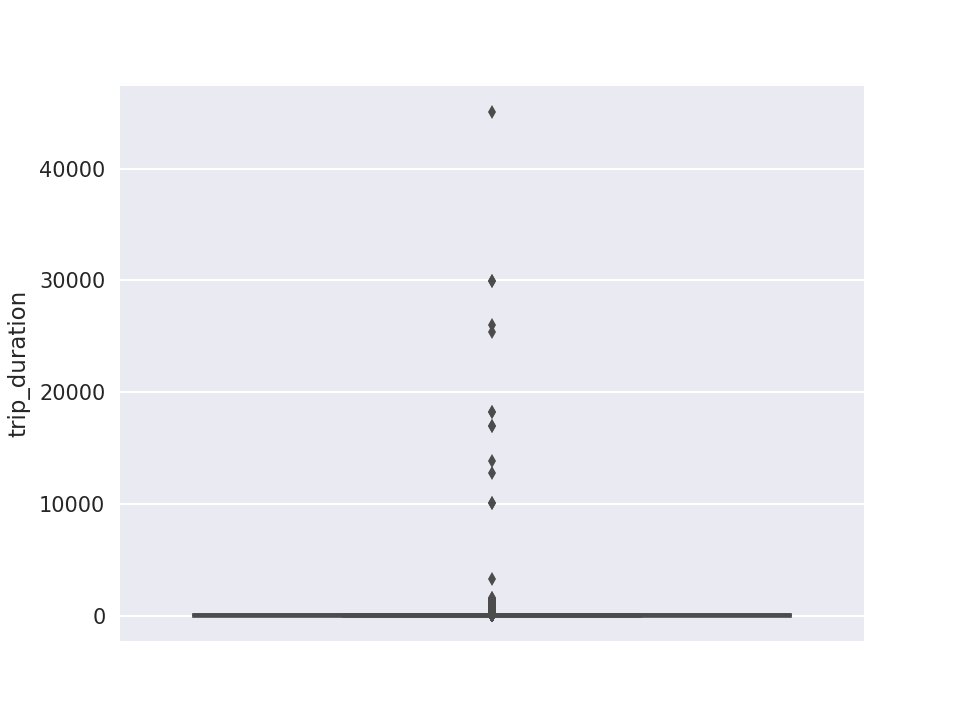

In [11]:
# the skewed box plot shows us the presence of outliers 
sns.boxplot(y='trip_duration', data =frame_with_durations)
plt.savefig('./data/trip_duration_box.png', 
                dpi=250, bbox_inches='tight')
plt.show()
plt.close()

In [12]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    var = frame_with_durations['trip_duration'].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is 0.016666666666666666
10 percentile value is 3.9166666666666665
20 percentile value is 5.45
30 percentile value is 6.883333333333334
40 percentile value is 8.35
50 percentile value is 9.983333333333333
60 percentile value is 11.9
70 percentile value is 14.3
80 percentile value is 17.616666666666667
90 percentile value is 23.35
100 percentile value is  45108.23333333333


In [13]:
#looking further from the 90th percecntile
for i in range(90,100):
    var =frame_with_durations['trip_duration'].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 23.35
91 percentile value is 24.25
92 percentile value is 25.25
93 percentile value is 26.4
94 percentile value is 27.766666666666666
95 percentile value is 29.4
96 percentile value is 31.466666666666665
97 percentile value is 34.233333333333334
98 percentile value is 38.4
99 percentile value is 46.35
100 percentile value is  45108.23333333333


In [14]:
#removing data based on our analysis and TLC regulations
frame_with_durations_modified = frame_with_durations[(frame_with_durations.trip_duration > 1) & 
                                            (frame_with_durations.trip_duration < 720)]

<IPython.core.display.Javascript object>


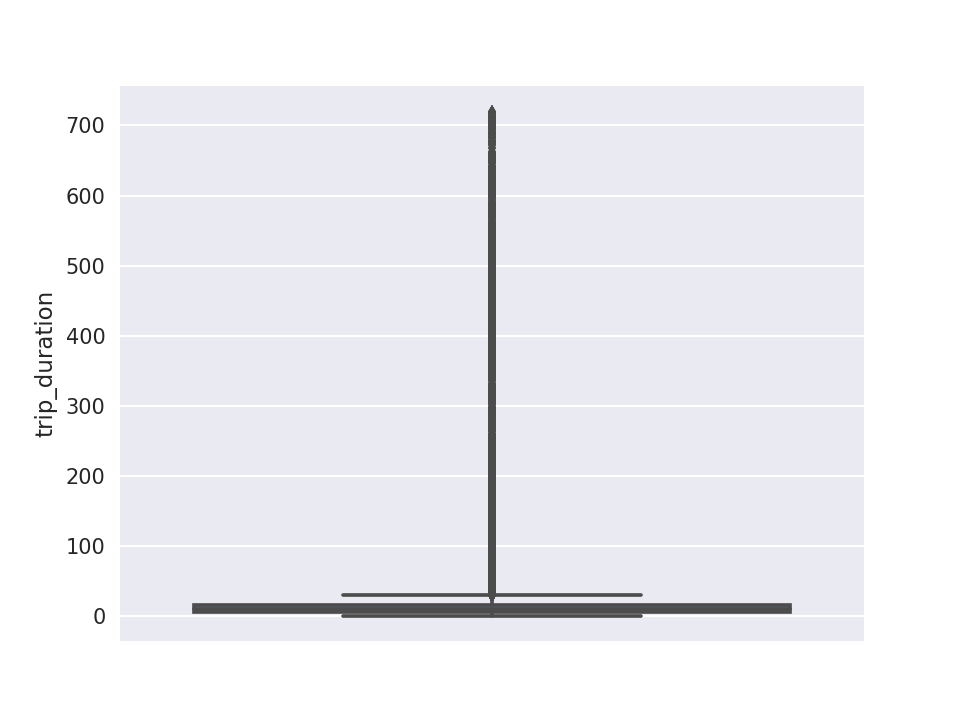

In [15]:
#box-plot after removal of outliers
sns.boxplot(y='trip_duration', data=frame_with_durations_modified)
plt.savefig('./data/trip_duration_boxplot_modified.png', 
                dpi=250, bbox_inches='tight')
plt.show()
plt.close()

<IPython.core.display.Javascript object>


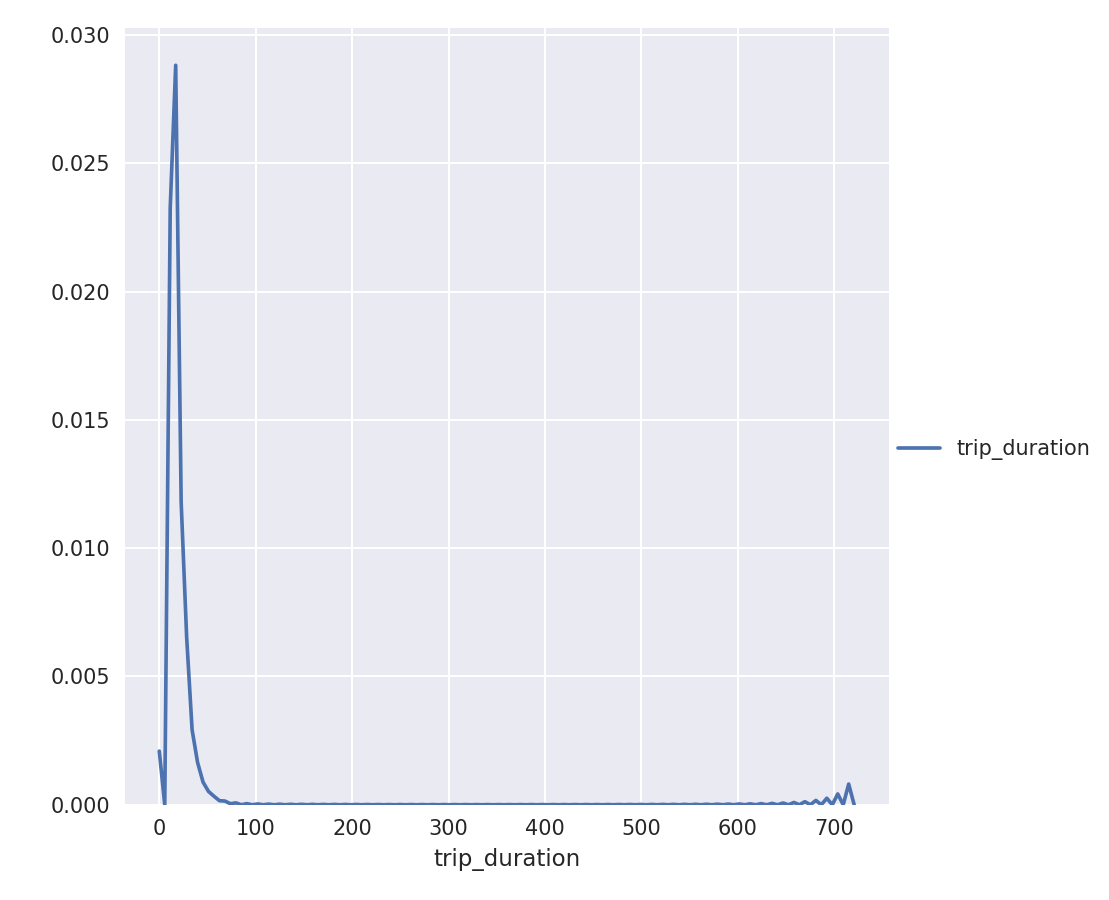

In [16]:
# pdf of trip-times after removing the outliers
sns.FacetGrid(frame_with_durations_modified,size=6) \
      .map(sns.kdeplot,'trip_duration') \
      .add_legend();
plt.savefig('./data/trip_duration_kde_modified.png', 
                dpi=250, bbox_inches='tight')
plt.show()
plt.close()

In [17]:
# converting to log to check log normal distribution
frame_with_durations_modified['log_times']=[math.log(i) for i in 
                              frame_with_durations_modified['trip_duration'].values]

/home/amd_3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


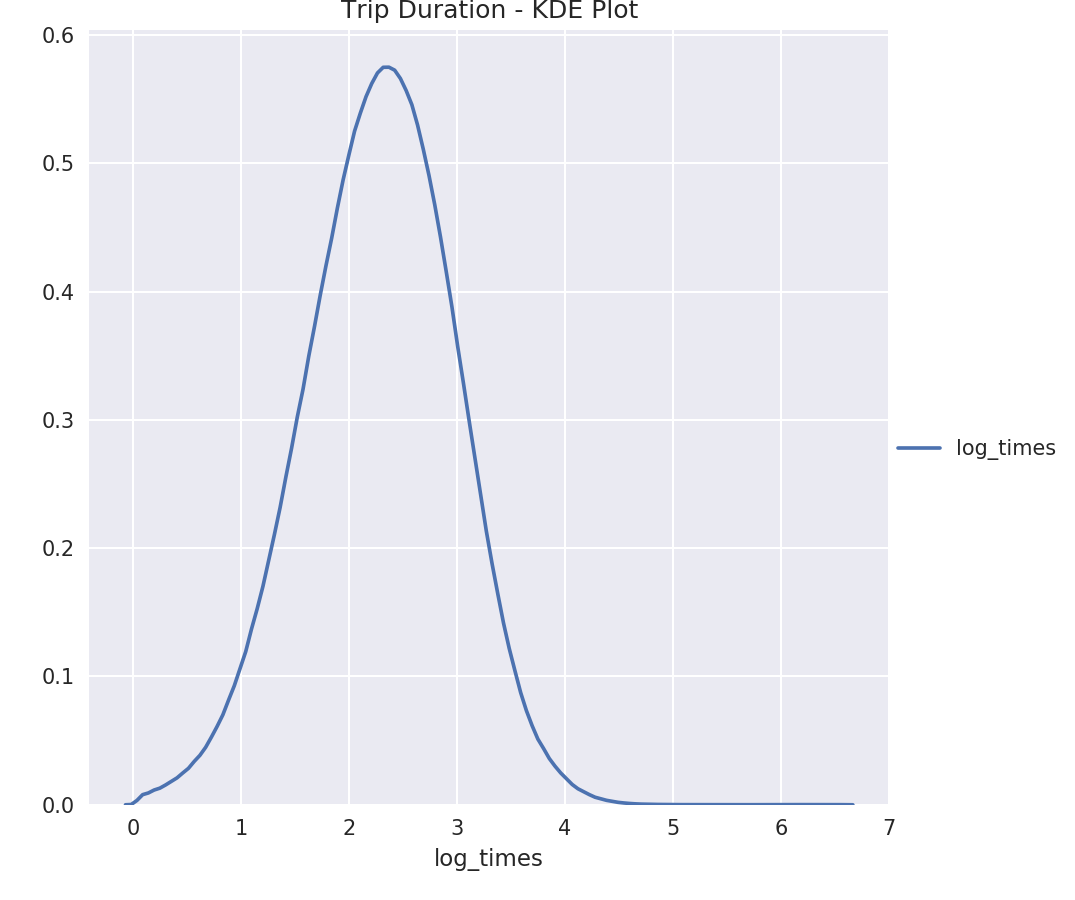

In [18]:
#pdf of log-values
sns.FacetGrid(frame_with_durations_modified,size=6).map(sns.kdeplot,"log_times").add_legend();
plt.title('Trip Duration - KDE Plot')
plt.savefig('./data/log_times.png', 
                dpi=250, bbox_inches='tight')
plt.show()
plt.close()

<IPython.core.display.Javascript object>


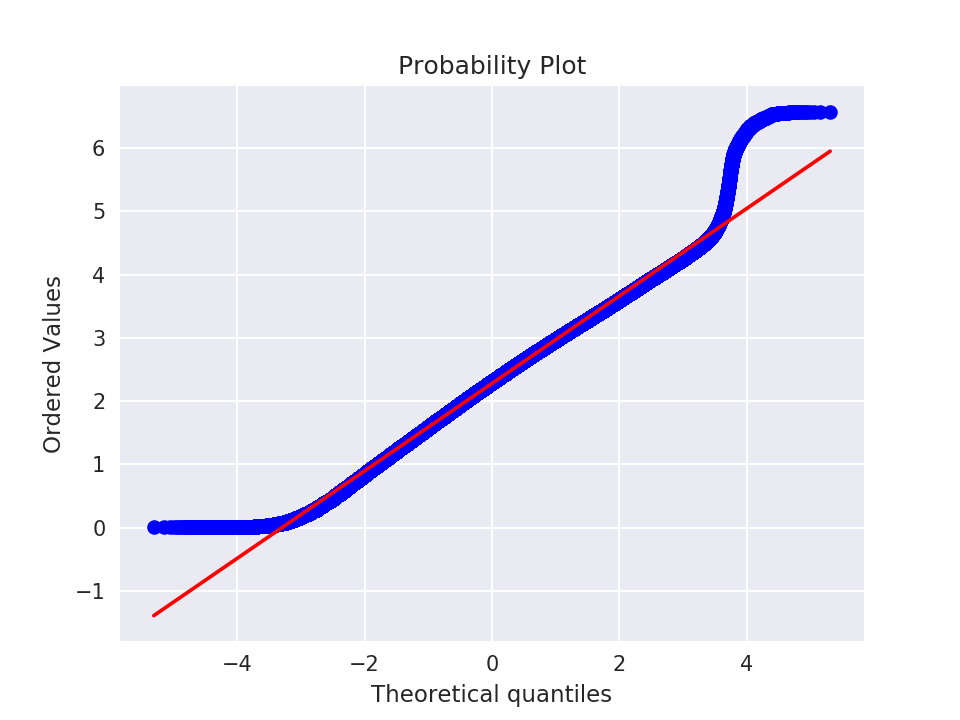

In [19]:
#Q-Q plot for checking if trip-times is log-normal
scipy.stats.probplot(frame_with_durations_modified['log_times'].values, plot=plt)
plt.savefig('./data/probplot_times.png', 
                dpi=250, bbox_inches='tight')
plt.show()
plt.close()

### 4. Speed

/home/amd_3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


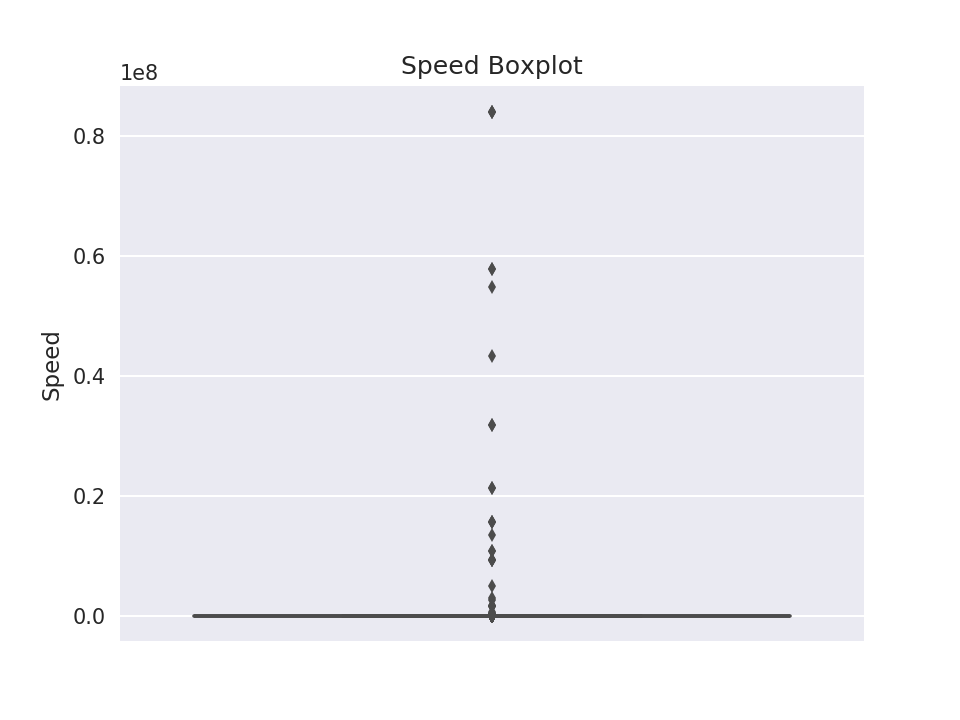

In [20]:
# check for any outliers in the data after trip duration outliers removed
# box-plot for speeds with outliers
frame_with_durations_modified['Speed'] = 60 * (frame_with_durations_modified['trip_distance'] / 
                                               frame_with_durations_modified['trip_duration'])
sns.boxplot(y='Speed', data =frame_with_durations_modified)
plt.title('Speed Boxplot')
plt.savefig('./data/speed_boxplot.png', 
                dpi=250, bbox_inches='tight')
plt.show()
plt.close()

In [21]:
#calculating speed values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =frame_with_durations_modified['Speed'].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.006547835576573299
10 percentile value is 6.428571428571428
20 percentile value is 7.821263482280432
30 percentile value is 8.934146341463416
40 percentile value is 9.981981981981981
50 percentile value is 11.065573770491804
60 percentile value is 12.277710109622411
70 percentile value is 13.779904306220097
80 percentile value is 15.929203539823007
90 percentile value is 20.08988764044944
100 percentile value is  83991500.86956523


In [22]:
#calculating speed values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90, 100):
    var =frame_with_durations_modified['Speed'].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 20.08988764044944
91 percentile value is 20.79779917469051
92 percentile value is 21.618798955613574
93 percentile value is 22.564102564102566
94 percentile value is 23.660777385159015
95 percentile value is 24.965753424657535
96 percentile value is 26.552315608919383
97 percentile value is 28.536030341340073
98 percentile value is 31.2280701754386
99 percentile value is 35.34475374732334
100 percentile value is  83991500.86956523


In [23]:
#calculating speed values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified['Speed'].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 35.34475374732334
99.1 percentile value is 35.90450928381963
99.2 percentile value is 36.498614958448755
99.3 percentile value is 37.16686674669867
99.4 percentile value is 37.916428162564394
99.5 percentile value is 38.75544492843808
99.6 percentile value is 39.73718791064389
99.7 percentile value is 40.949681077250176
99.8 percentile value is 42.48927038626609
99.9 percentile value is 44.815909090909095
100 percentile value is  83991500.86956523


In [24]:
# removing further outliers based on the 99.9th percentile value
frame_with_durations_modified = frame_with_durations[(frame_with_durations.Speed > 0) & 
                                                     (frame_with_durations.Speed < 45.31)]

In [25]:
# avg.speed of cabs in New-York
sum(frame_with_durations_modified['Speed']) / float(len(frame_with_durations_modified['Speed']))

12.416090317333259

<b style='font-size:16px'>The avg speed in Newyork speed is 12.45miles/hr, so a cab driver can travel <font color='blue'> 2 miles per 10min on avg.</font> </b>

### 4. Trip Distance

<IPython.core.display.Javascript object>


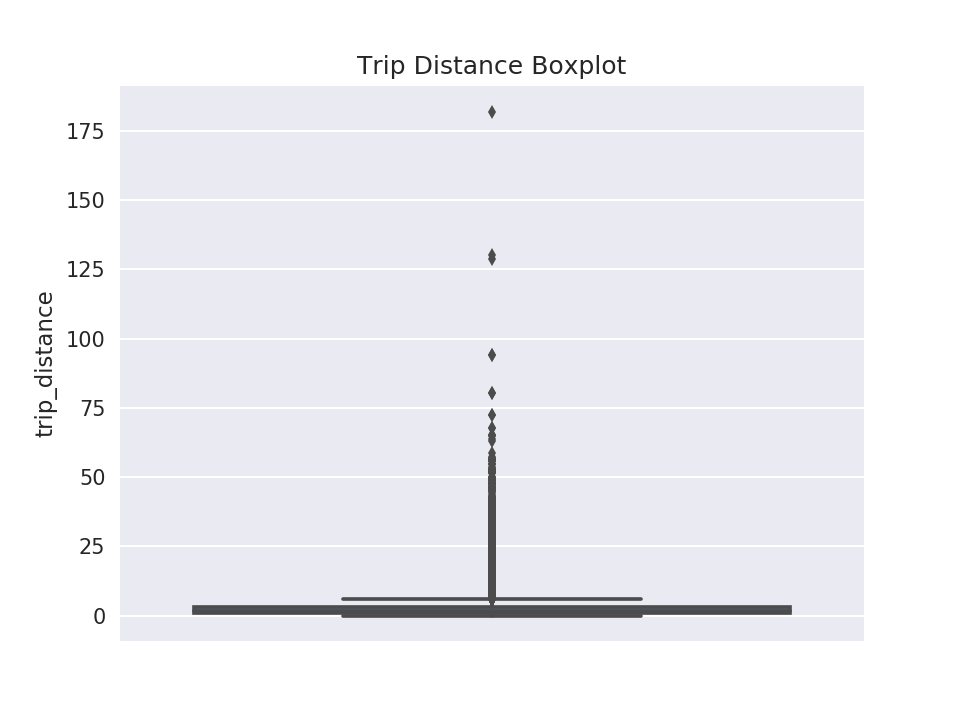

In [26]:
# up to now we have removed the outliers based on trip durations and cab speeds
# lets try if there are any outliers in trip distances
# box-plot showing outliers in trip-distance values

sns.boxplot(y='trip_distance', data =frame_with_durations_modified)
plt.title('Trip Distance Boxplot')
plt.savefig('./data/trip_distance.png', 
                dpi=250, bbox_inches='tight')
plt.show()
plt.close()

In [27]:
#calculating trip distance values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var = frame_with_durations_modified['trip_distance'].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.01
10 percentile value is 0.66
20 percentile value is 0.9
30 percentile value is 1.1
40 percentile value is 1.38
50 percentile value is 1.69
60 percentile value is 2.06
70 percentile value is 2.6
80 percentile value is 3.57
90 percentile value is 5.9
100 percentile value is  181.96


In [28]:
#calculating trip distance values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var =frame_with_durations_modified['trip_distance'].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 5.9
91 percentile value is 6.38
92 percentile value is 6.95
93 percentile value is 7.7
94 percentile value is 8.6
95 percentile value is 9.44
96 percentile value is 10.4
97 percentile value is 11.75
98 percentile value is 15.4
99 percentile value is 18.0
100 percentile value is  181.96


In [29]:
#calculating trip distance values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations_modified['trip_distance'].values
    var = np.sort(var, axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 18.0
99.1 percentile value is 18.2
99.2 percentile value is 18.41
99.3 percentile value is 18.68
99.4 percentile value is 18.95
99.5 percentile value is 19.3
99.6 percentile value is 19.7
99.7 percentile value is 20.27
99.8 percentile value is 20.93
99.9 percentile value is 21.98
100 percentile value is  181.96


In [30]:
# removing further outliers based on the 99.9th percentile value
frame_with_durations_modified = frame_with_durations[(frame_with_durations.trip_distance > 0) & 
                                                   (frame_with_durations.trip_distance < 23)]

<IPython.core.display.Javascript object>


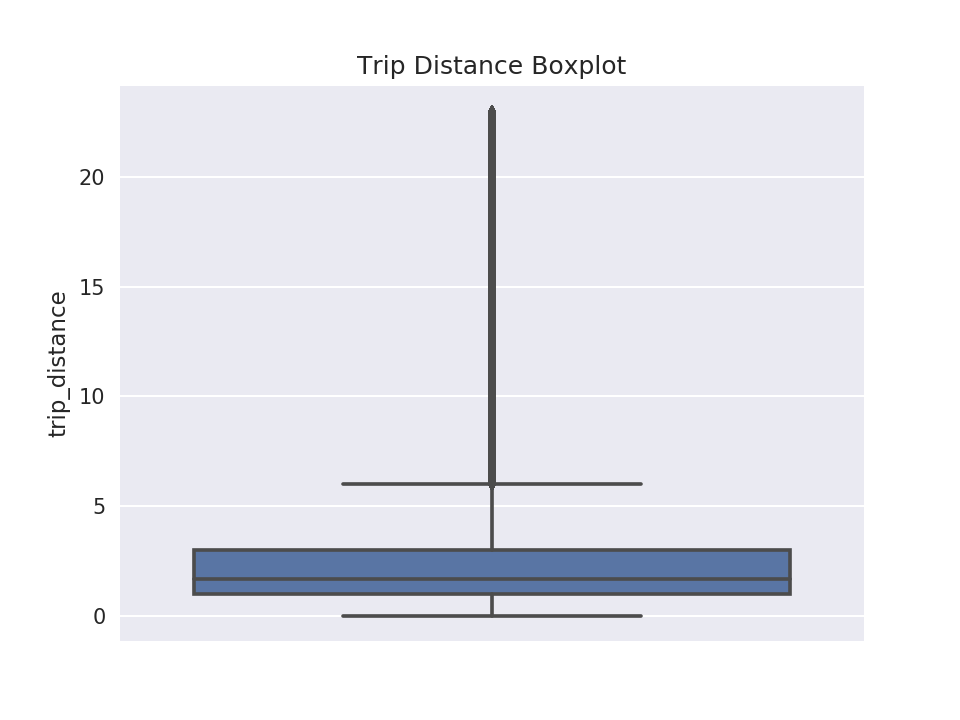

In [31]:
#box-plot after removal of outliers
sns.boxplot(y='trip_distance', data = frame_with_durations_modified)
plt.title('Trip Distance Boxplot')
plt.savefig('./data/trip_distance_boxplot.png', 
                dpi=250, bbox_inches='tight')
plt.show()
plt.close()

### 5. Total Fare

<IPython.core.display.Javascript object>


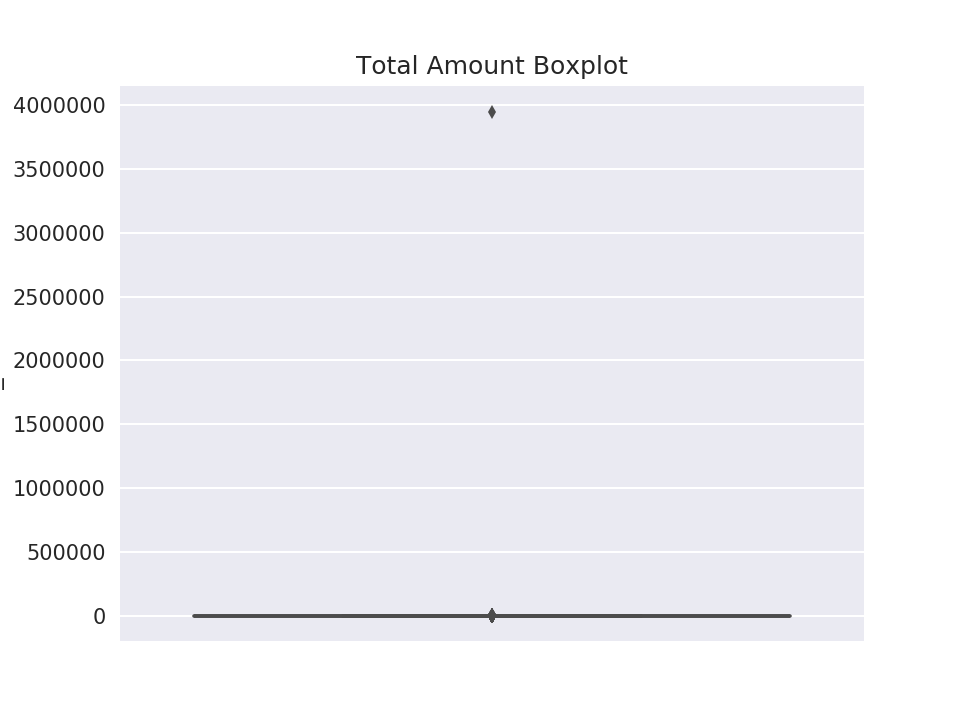

In [32]:
# up to now we have removed the outliers based on trip durations, cab speeds, and trip distances
# lets try if there are any outliers in based on the total_amount
# box-plot showing outliers in fare
sns.boxplot(y='total_amount', data =frame_with_durations_modified)
plt.title('Total Amount Boxplot')
plt.savefig('./data/total_amount_box_plot.png', 
                dpi=250, bbox_inches='tight')
plt.show()
plt.close()

In [33]:
#calculating total fare amount values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var = frame_with_durations_modified['total_amount'].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 6.32
20 percentile value is 7.8
30 percentile value is 8.8
40 percentile value is 9.8
50 percentile value is 11.16
60 percentile value is 12.8
70 percentile value is 14.8
80 percentile value is 18.2
90 percentile value is 25.56
100 percentile value is  3950611.6


In [34]:
#calculating total fare amount values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var = frame_with_durations_modified['total_amount'].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 25.56
91 percentile value is 27.2
92 percentile value is 28.99
93 percentile value is 31.3
94 percentile value is 34.3
95 percentile value is 37.8
96 percentile value is 41.75
97 percentile value is 46.95
98 percentile value is 55.8
99 percentile value is 64.13
100 percentile value is  3950611.6


In [35]:
#calculating total fare amount values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations_modified['total_amount'].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 64.13
99.1 percentile value is 65.8
99.2 percentile value is 67.13
99.3 percentile value is 68.6
99.4 percentile value is 69.6
99.5 percentile value is 69.6
99.6 percentile value is 69.73
99.7 percentile value is 69.76
99.8 percentile value is 72.46
99.9 percentile value is 72.88
100 percentile value is  3950611.6


<b>Observation:-</b> As even the 99.9th percentile value doesnt look like an outlier,as there is not much difference between the 99.8th percentile and 99.9th percentile, we move on to do graphical analyis

<IPython.core.display.Javascript object>


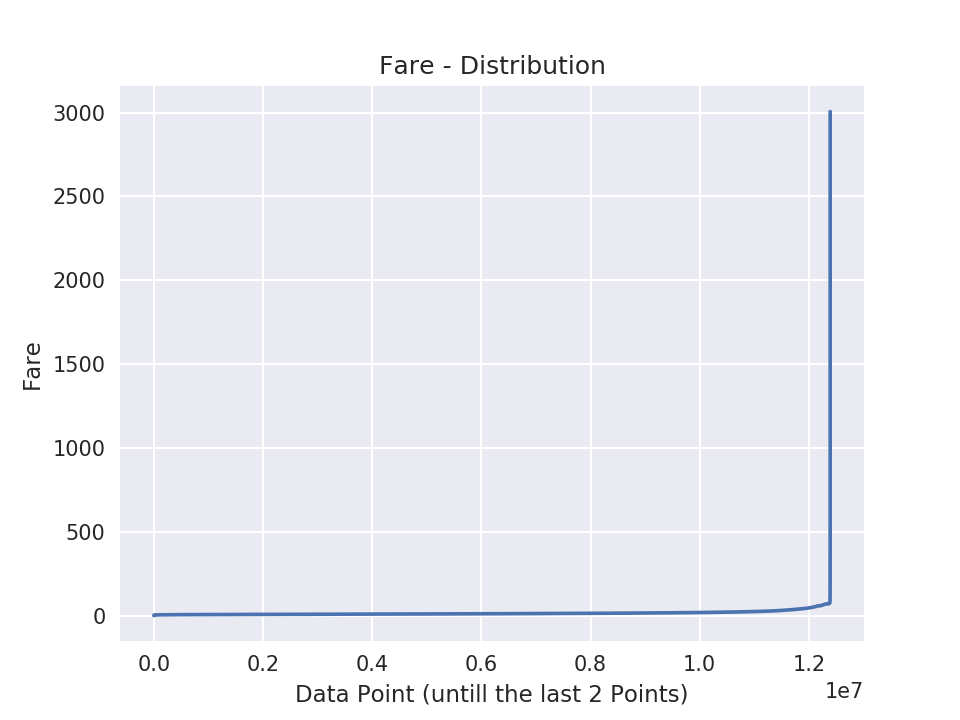

In [36]:
#below plot shows us the fare values(sorted) to find a sharp increase to remove those values as outliers
# plot the fare amount excluding last two values in sorted data
plt.plot(var[:-2])
plt.xlabel('Data Point (untill the last 2 Points)')
plt.ylabel('Fare')
plt.title('Fare - Distribution')
plt.savefig('./data/Fare_Distribution_last_2.png', 
                dpi=250, bbox_inches='tight')
plt.show()
plt.close()

<IPython.core.display.Javascript object>


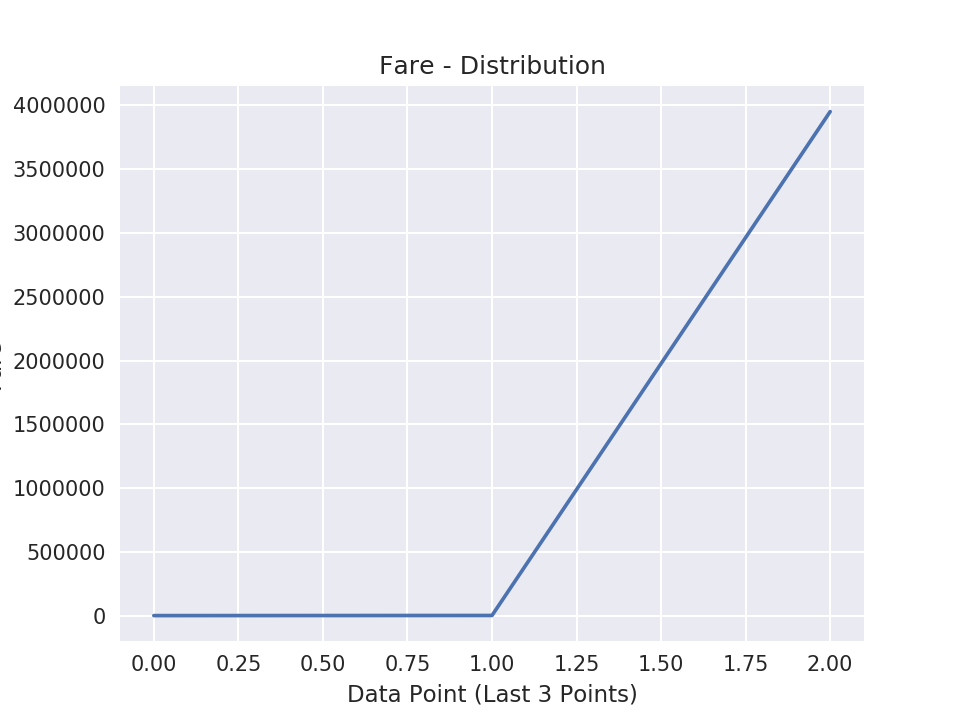

In [37]:
# a very sharp increase in fare values can be seen 
# plotting last three total fare values, and we can observe there is share increase in the values
plt.plot(var[-3:])
plt.xlabel('Data Point (Last 3 Points)')
plt.ylabel('Fare')
plt.title('Fare - Distribution')
plt.savefig('./data/Fare_Distribution_last_three.png', 
                dpi=250, bbox_inches='tight')
plt.show()
plt.close()

<IPython.core.display.Javascript object>


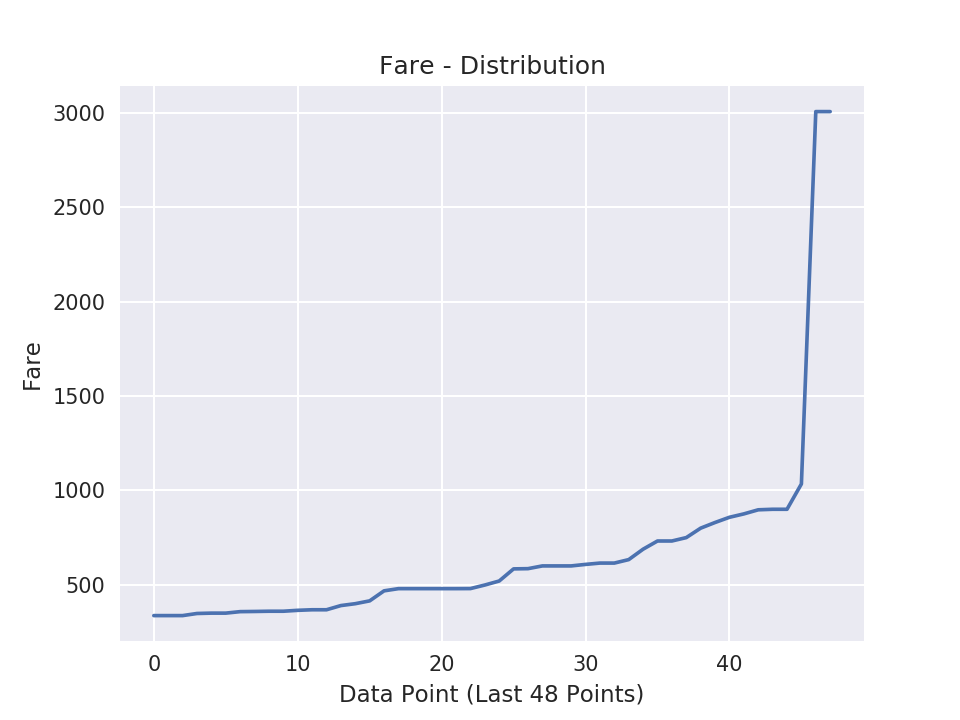

In [38]:
#now looking at values not including the last two points we again find a drastic increase at around 1000 fare value
# we plot last 50 values excluding last two values
plt.plot(var[-50:-2])
plt.xlabel('Data Point (Last 48 Points)')
plt.ylabel('Fare')
plt.title('Fare - Distribution')
plt.savefig('./data/Fare_Distribution_last_48.png', 
                dpi=250, bbox_inches='tight')
plt.show()
plt.close()

## Remove all outliers/erronous points.

In [39]:
#removing all outliers based on our univariate analysis above
def remove_outliers(new_frame_path, data_info):
    
    print('='*80)
    
    print('Currently processing : ', data_info, '\n\n')
    
    new_frame = dd.read_csv(new_frame_path)
    new_frame = new_frame.sample(frac=sample_frac, replace=True)
    
    # rename column
    new_frame = new_frame.rename(columns={'RateCodeID' : 'RatecodeID'})
    initial_size = len(new_frame)
    
    print ('Number of initial pickup records = ', initial_size)
    
    # do a priliminary check and discard records which doenst satisfy the conditions
    new_frame = preliminary_check(new_frame)
    
    # add trip duation, speed 
    new_frame = return_with_trip_duration(new_frame)

    a = len(new_frame)
    print ('Number of initial pickup records = ', initial_size)
    
    # remove outliers based on longitude latitude 
    temp_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    
    b = len(temp_frame)
    print ("Number of outlier coordinates lying outside NY boundaries:",(a-b))
    
    temp_frame = new_frame[(new_frame.trip_duration > 0) & (new_frame.trip_duration < 720)]
    c = len(temp_frame)
    print ("Number of outliers from trip times analysis:",(a-c))
    
    
    temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    d = len(temp_frame)
    print ("Number of outliers from trip distance analysis:",(a-d))
    
    temp_frame = new_frame[(new_frame.Speed <= 65) & (new_frame.Speed >= 0)]
    e = len(temp_frame)
    print ("Number of outliers from speed analysis:",(a-e))
    
    temp_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    f = len(temp_frame)
    print ("Number of outliers from fare analysis:",(a-f))
    
    
    
    # ==================================== Remove all outlier points ============================================
    
    # Remove based on longitude & latitude
    new_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    
    # remove based on trip duration
    new_frame = new_frame[(new_frame.trip_duration > 0) & (new_frame.trip_duration < 720)]
    # remove based on trip distance
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    # remove based on speed
    new_frame = new_frame[(new_frame.Speed < 45.31) & (new_frame.Speed > 0)]
    # remove based on total amount
    new_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    
    final_size = len(new_frame)
    print ("Total outliers removed", initial_size - final_size)
    
    print('fraction of data points that remain after removing all outliers', 
      float(final_size/initial_size))
    
    # get only the required columns
    new_frame = new_frame[['trip_distance','pickup_longitude', 'pickup_latitude','dropoff_longitude',
                           'dropoff_latitude', 'passenger_count', 'total_amount', 'Speed', 'trip_duration',
                          'trip_distance', 'pickup_times']]
    
    print('='*80)
    
    return new_frame

In [40]:
print ('Removing outliers in the month of Jan-2015')
print ("----")

frame_path = os.path.join(base_dir,'yellow_tripdata_2015-01.csv')
cleaned_data = remove_outliers(frame_path, 'January 2015')

Removing outliers in the month of Jan-2015
----
Currently processing :  January 2015 


Number of initial pickup records =  12748986
Initial number of records:12748986
After removing some invalid records the number of records:12659026
Number of initial pickup records =  12748986
Number of outlier coordinates lying outside NY boundaries: 261560
Number of outliers from trip times analysis: 8622
Number of outliers from trip distance analysis: 13153
Number of outliers from speed analysis: 9416
Number of outliers from fare analysis: 126
Total outliers removed 385195
fraction of data points that remain after removing all outliers 0.969786224567193


# Data-preperation
## Clustering/Segmentation

In [41]:
# trying different cluster sizes to choose the right K in K-means
coords = cleaned_data[['pickup_latitude', 'pickup_longitude']].values

In [42]:
def get_pair_distance_km(point_1, point_2):
    
    # get longitude, latitude separately
    long_1, lat_1 = point_1
    long_2, lat_2 = point_2
    
    # compute distnace
    distance = gpxpy.geo.haversine_distance(long_1, lat_1, long_2, lat_2)
    # convert to miles
    distance /= (1.60934 * 1000)
    
    return distance

In [43]:
def get_cluster_distances(cluster_centers_list):
    
    # get number of clusters
    num_clusters = len(cluster_centers_list)
    
    # declare two lists for more distances & less distances
    more_list = list()
    less_list = list()
    distance_list = list()
    
    # compute distance to each clusters
    for out_index, current_cluster_center in enumerate(cluster_centers_list):
        
        more_count = 0
        less_count = 0
        
        # do for
        for in_index, in_cluster_center in enumerate(cluster_centers_list):
            
            if out_index == in_index:
                continue
            
            # computet the distance between clusters
            dist = get_pair_distance_km(current_cluster_center, in_cluster_center)
            # add distance to the list
            distance_list.append(dist)
            
            if dist > 2:
                more_count = more_count + 1
            else:
                less_count = less_count + 1
            
            
        more_list.append(more_count)
        less_list.append(less_count)
        
    
    # compute minimum intercluster distance
    min_inter_clust_distance = min(distance_list)
    
    print("""\n With %d clusters :\n 
             mean # clusters within the vicinity:%f, 
             mean # clusters outside the vicinity:%f
             minimum intercluster distance : %f miles"""%(num_clusters, 
                                                    np.mean(less_list),
                                                    np.mean(more_list),
                                                    min_inter_clust_distance,))
    

In [44]:
def find_clusters(num_clusters, coords):
    
    # create an object for clustering
    kmeans = MiniBatchKMeans(n_clusters=num_clusters, batch_size=10000, random_state=42)
    
    # fit on the data
    kmeans.fit(coords)
    
    # add labels to the data frame
    #frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.labels_
    
    # Get cluster centers
    cluster_centers = kmeans.cluster_centers_
    
    return cluster_centers

# we need to choose number of clusters so that, there are more number of cluster regions 
# that are close to any cluster center # and make sure that the minimum inter cluster should not be very less
for num_clusters in range(10, 100, 10):
    # get cluster centers
    cluster_centers = find_clusters(num_clusters, coords)
    # find cluster distances
    get_cluster_distances(list(cluster_centers))            


 With 10 clusters :
 
             mean # clusters within the vicinity:2.000000, 
             mean # clusters outside the vicinity:7.000000
             minimum intercluster distance : 0.926623 miles

 With 20 clusters :
 
             mean # clusters within the vicinity:4.700000, 
             mean # clusters outside the vicinity:14.300000
             minimum intercluster distance : 0.545349 miles

 With 30 clusters :
 
             mean # clusters within the vicinity:6.800000, 
             mean # clusters outside the vicinity:22.200000
             minimum intercluster distance : 0.444296 miles

 With 40 clusters :
 
             mean # clusters within the vicinity:9.400000, 
             mean # clusters outside the vicinity:29.600000
             minimum intercluster distance : 0.390313 miles

 With 50 clusters :
 
             mean # clusters within the vicinity:12.440000, 
             mean # clusters outside the vicinity:36.560000
             minimum intercluster distance : 

### Inference:
- The main objective was to find a optimal min. distance(Which roughly estimates to the radius of a cluster) between the clusters which we got is 30
- The value k=30 is choosen based on the minimum intercluster distance >= ~0.50 and the number of clusters which are in vicinity (dist < 2 miles) is higher

In [45]:
# if check for the 50 clusters you can observe that there are two clusters with only 0.3 miles 
# apart from each other so we choose 30 clusters to solve the further problem

# Getting 40 clusters using the kmeans 
kmeans = MiniBatchKMeans(n_clusters=30, batch_size=10000,random_state=0)
kmeans.fit(coords)

# add the cluster centers
cleaned_data['pickup_cluster'] = kmeans.labels_
cleaned_data.head()

pickle_out = open('./model/NYC_kmeans_model.pickle','wb')
pickle.dump(kmeans, pickle_out)
pickle_out.close()

### Plotting the cluster centers:

In [46]:
# Plotting the cluster centers on OSM
cluster_centers = kmeans.cluster_centers_
cluster_len = len(cluster_centers)
map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')
for i in range(cluster_len):
    folium.Marker(list((cluster_centers[i][0],cluster_centers[i][1])), 
                  popup=(str(cluster_centers[i][0])+str(cluster_centers[i][1]))).add_to(map_osm)
    
display(map_osm)
map_osm.save('./data/map.html')

### Plotting the clusters:

In [47]:
#Visualising the clusters on a map
def plot_clusters(frame):
    city_long_border = (-74.03, -73.75)
    city_lat_border = (40.63, 40.85)
    fig, ax = plt.subplots(ncols=1, nrows=1)
    ax.scatter(frame.pickup_longitude.values[:100000], frame.pickup_latitude.values[:100000], s=10, lw=0,
               c=frame.pickup_cluster.values[:100000], cmap='tab20', alpha=0.2)
    ax.set_xlim(city_long_border)
    ax.set_ylim(city_lat_border)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.title('Clustering of Pickups')
    plt.savefig('./data/Clustering_of_Pickups.png', 
                dpi=250, bbox_inches='tight')
    plt.show()
    plt.close()

<IPython.core.display.Javascript object>


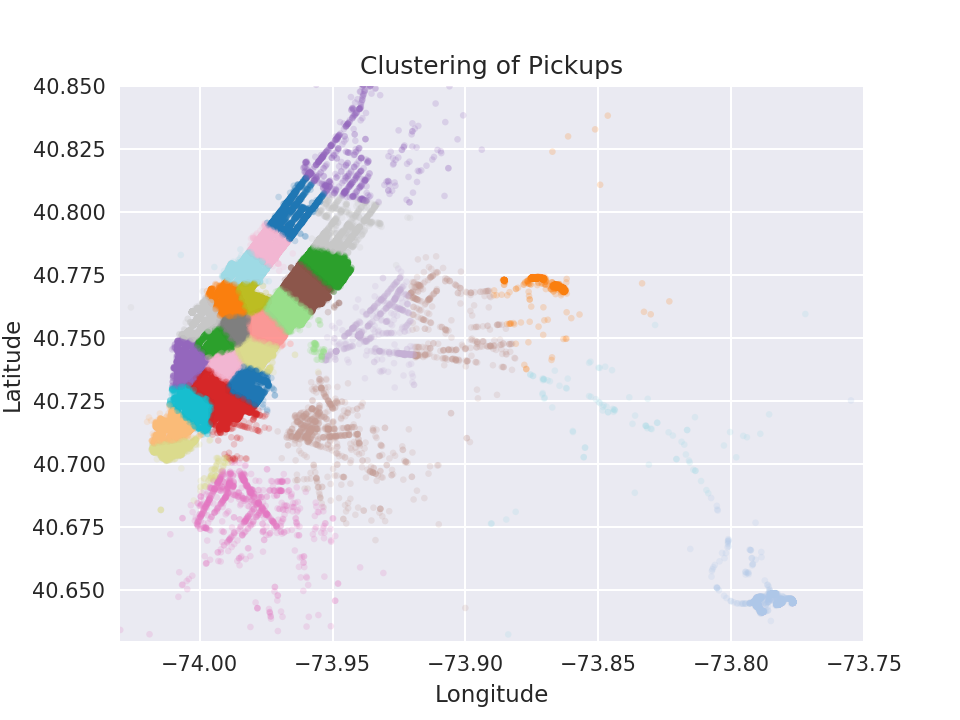

In [48]:
plot_clusters(cleaned_data)

<h3> Observations </h3>
<ul>
<li> K-means tends to form clusters of equal size, there are some clusters in the figure that occupy large area
     compared to others, this means that the clustering is not based on the geographic area but the number of
    pickups</li>
<li> Manhatten area has got many clusters which means the number of pickups in that are is very high compared to
     other areas </li>
<li> Central park area has no pickup.- this is expected </li>
</ul>

## Time-binning

In [49]:
#Refer:https://www.unixtimestamp.com/
# 1420070400 : 2015-01-01 00:00:00 
# 1422748800 : 2015-02-01 00:00:00 
# 1425168000 : 2015-03-01 00:00:00
# 1427846400 : 2015-04-01 00:00:00 
# 1430438400 : 2015-05-01 00:00:00 
# 1433116800 : 2015-06-01 00:00:00

# 1451606400 : 2016-01-01 00:00:00 
# 1454284800 : 2016-02-01 00:00:00 
# 1456790400 : 2016-03-01 00:00:00
# 1459468800 : 2016-04-01 00:00:00 
# 1462060800 : 2016-05-01 00:00:00 
# 1464739200 : 2016-06-01 00:00:00

unix_time_dict = {
    2015 :{
            'January' : 1420070400,
            'February' : 1422748800,
            'March' : 1425168000
            },
    
    2016 :{
            'January' : 1451606400,
            'February' : 1454284800,
            'March' : 1456790400
            }
}


def add_pickup_bins(frame, year, month):
    
    # get pickup time stamps in a list
    unix_pickup_times = [i for i in frame['pickup_times'].values]

    # convert pickup timestamps to unix timestamp
    start_pickup_unix = unix_time_dict[year][month]
    
    # https://www.timeanddate.com/time/zones/est (int((i-start_pickup_unix)/600)+33)
    # Convert unix timestamps to EST
    tenminutewise_binned_unix_pickup_times=[(int((i-start_pickup_unix)/600)+33) 
                                            for i in unix_pickup_times]
    
    frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    
    return frame

In [50]:
cleaned_data  = add_pickup_bins(cleaned_data, 2015, 'January')

## Smoothing

In [51]:
# upto now we cleaned data and prepared data for the month 2015,

# now do the same operations for months Jan, Feb, March of 2016
# 1. get the dataframe which inlcudes only required colums
# 2. adding trip times, speed, unix time stamp of pickup_time
# 4. remove the outliers based on trip_times, speed, trip_duration, total_amount
# 5. add pickup_cluster to each data point
# 6. add pickup_bin (index of 10min intravel to which that trip belongs to)
# 7. group by data, based on 'pickup_cluster' and 'pickuo_bin'

# Data Preparation for the months of Jan,Feb and March 2016

bins_dict = {
    
    2015 : {'January': 4464,
            'February': 4032, # non-leap year
            'March': 4464},
    2016 :
            {'January': 4464,
            'February': 4176, # leap year
            'March': 4464},
    2017 : {
            'January': 4464,
            'February': 4032, # non-leap year
            'March': 4464
           }
}

there are two ways to fill up these values
<ul>
<li> Fill the missing value with 0's</li>
<li> Fill the missing values with the avg values
<ul>
<li> Case 1:(values missing at the start)  <br>Ex1: \_ \_ \_ x =>ceil(x/4), ceil(x/4), ceil(x/4), ceil(x/4) <br> Ex2: \_ \_ x => ceil(x/3), ceil(x/3), ceil(x/3) </li>
<li> Case 2:(values missing in middle) <br>Ex1: x \_ \_ y => ceil((x+y)/4), ceil((x+y)/4), ceil((x+y)/4), ceil((x+y)/4) <br> Ex2: x \_ \_ \_ y => ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5) </li>
<li> Case 3:(values missing at the end)  <br>Ex1: x \_ \_ \_  => ceil(x/4), ceil(x/4), ceil(x/4), ceil(x/4) <br> Ex2: x \_  => ceil(x/2), ceil(x/2) </li>
</ul>
</li>
</ul>

In [52]:
def fill_with_zeros(df, max_regions, max_bins):
    
    # declare two sets of all possible regions and bins
    regions_set = set(range(0, max_regions))
    bins_set = set(range(0, max_bins))
    
    group_columns = ['pickup_cluster', 'pickup_bins']
    required_columns = group_columns + ['passenger_count']
    full_columns = group_columns + ['count']
    
    # get a group by count 
    grp_count_df = df[required_columns].groupby(group_columns).count().reset_index()
    grp_count_df.rename(columns={'passenger_count':'count'}, inplace=True)
    print(grp_count_df.dtypes)
    
    # compute missing bins & regions
    missing_regions = regions_set - set(grp_count_df['pickup_cluster'])
    missing_bins = bins_set - set(grp_count_df['pickup_bins'])
    
    if not missing_regions:
        missing_regions = {0}
    if not missing_bins:
        missing_bins = {0}    
    
    # compute missing bins , regions pairs
    missing_tuples = product(missing_regions, missing_bins)
    
    
    # fill zero val for missing pairs
    missing_tuples = [item + (0,) for item in list(missing_tuples)]
    
    # create missing df
    missing_df = pd.DataFrame(missing_tuples, columns=full_columns)
    
    # create pivot df
    if not missing_df.empty:
        pivot_df = grp_count_df.append(missing_df)
    else:
        pivot_df = grp_count_df
        
    pivot_df = pivot_df.reset_index(drop=True)
    pivot_df = pivot_df.sort_values(group_columns)
    
    # pivot the table
    pivot_df = pd.pivot_table(data=pivot_df, 
                              index='pickup_cluster', 
                              columns='pickup_bins', 
                              values='count', 
                              fill_value=0)
    return pivot_df

In [53]:
def smooth_list(tp_list):

    start_val = 0
    end_val = 0
    marked_already = False

    for index, item in enumerate(tp_list):

        if item == 0 and not marked_already:

            # get start index and start value
            start_pos = max(0, index - 1)
            start_val = tp_list[start_pos]
            marked_already = True

        elif item != 0 and marked_already:

            # get end index and end value
            end_pos = index
            end_val = tp_list[end_pos]
            marked_already = False

            # get total elements in this segment
            num_elements = (end_pos - start_pos) + 1

            # computet the value to substitute
            substitute_value = math.ceil((start_val + end_val) /   num_elements)
            #print('Start:',start_pos ,'End:',end_pos, 'substitute:', substitute_value)

            # smooth the list
            tp_list[start_pos : end_pos + 1] = [substitute_value] *  num_elements

        else:
            continue

    if marked_already:

        # get the end index & its corresponding value
        end_pos = index
        end_val = tp_list[end_pos]

        # get total elements in this segment
        num_elements = (end_pos - start_pos) + 1

        # computet the value to substitute
        substitute_value = math.ceil((start_val + end_val) / num_elements)
        #print('Start:',start_pos ,'End:',end_pos, 'substitute:', substitute_value)

        # smooth the list
        tp_list[start_pos : end_pos + 1] = [substitute_value] *  num_elements
        
        
    return tp_list

In [54]:
def smooth_data(zero_filled_df, num_clusters, num_bins):
    
    smoothed_data = list()
    
    # smooth each row
    for index, row in zero_filled_df.iterrows():
        smoothed_data.append(smooth_list(row.tolist()))
        
    smoothed_df = pd.DataFrame(smoothed_data)
        
    return smoothed_df   

In [55]:
#Filling Missing values of Jan-2015 with 0
# here in jan_2015_groupby dataframe the trip_distance represents the number of pickups that are happened
#jan_2015_fill = fill_missing(jan_2015_groupby['trip_distance'].values,jan_2016_unique)
jan_2015_fill = fill_with_zeros(cleaned_data, 30, 4464)

print(jan_2015_fill.head())

print('Number of zero pickups in each cluster:\n\n')
zero_pickups_info = (jan_2015_fill == 0).astype(int).sum(axis=1)

pickup_cluster    int64
pickup_bins       int64
count             int64
dtype: object
pickup_bins     0     1     2     3     4     5     6     7     8     9     \
pickup_cluster                                                               
0                  0    28   110   158   152   177   177   201   188   195   
1                  0   122   230   266   267   246   308   261   279   275   
2                  0    26    29    55    46    21    23    23    20    13   
3                  0    53    27    20    20    13    14    16    13    13   
4                  0   110   242   195   174   189   143   169   140   142   

pickup_bins     ...   4454  4455  4456  4457  4458  4459  4460  4461  4462  \
pickup_cluster  ...                                                          
0               ...    110   131    96   105    95    91    71    96    94   
1               ...    285   276   262   310   301   276   352   274   317   
2               ...     46    61    50    49    50    4

In [56]:
#Smoothing Missing values of Jan-2015
#jan_2015_smooth = smoothing(jan_2015_groupby['trip_distance'].values,jan_2016_unique)
jan_2015_smooth = smooth_data(jan_2015_fill, 30, 4464)

<IPython.core.display.Javascript object>


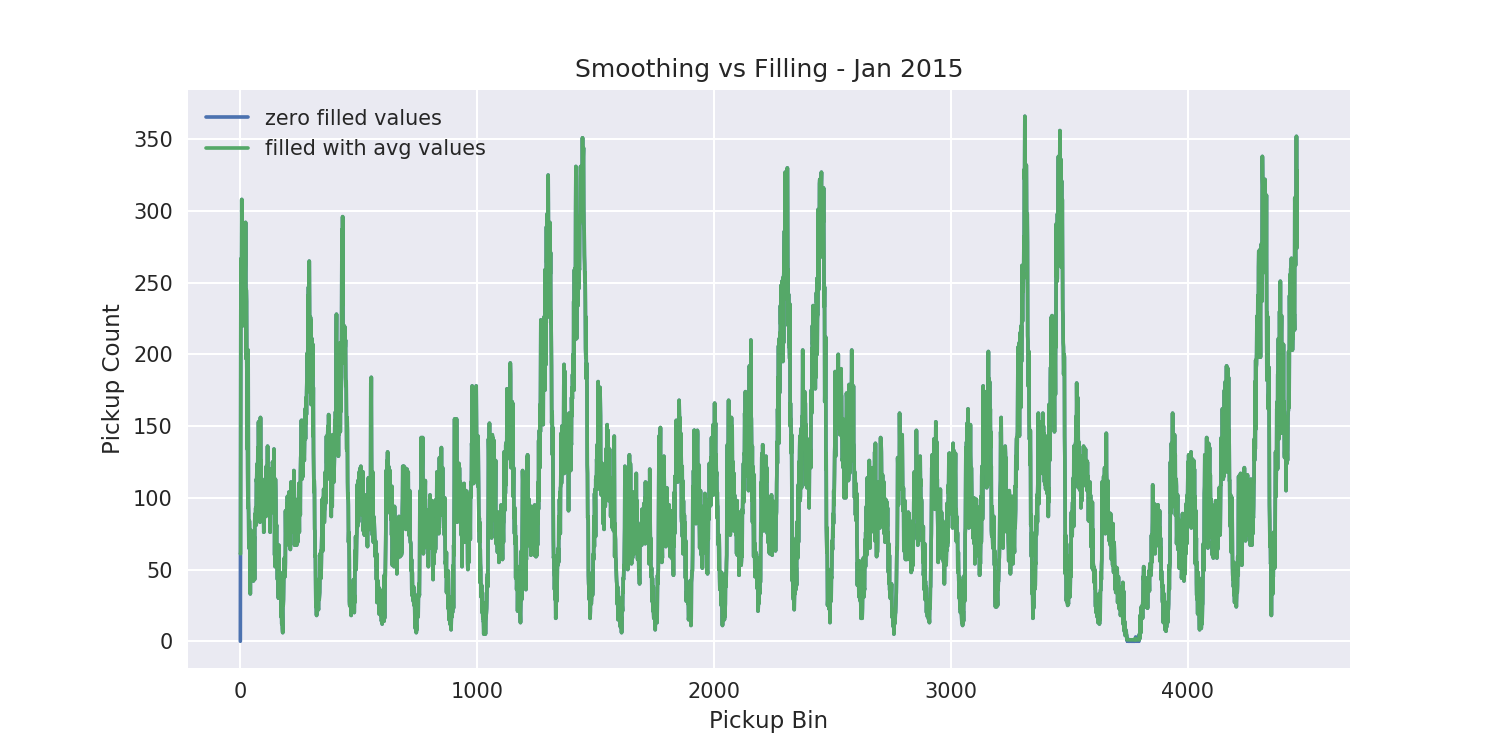

In [57]:
# Smoothing vs Filling
# sample plot that shows two variations of filling missing values
# we have taken the number of pickups for cluster region 2
plt.figure(figsize=(10,5))
plt.plot(jan_2015_fill.values[1], label='zero filled values')
plt.plot(jan_2015_smooth.values[1], label='filled with avg values')
plt.xlabel('Pickup Bin')
plt.ylabel('Pickup Count')
plt.title('Smoothing vs Filling - Jan 2015')
plt.legend()
plt.savefig('./data/Smoothing_vs_Filling_Jan 2015.png', 
                dpi=250, bbox_inches='tight')
plt.show()
plt.close()

%%HTML
why we choose, these methods and which method is used for which data?

 Ans: consider we have data of some month in 2015 jan 1st, 10 _ _ _ 20, i.e there are 10 pickups that are happened in 1st 
10st 10min intravel, 0 pickups happened in 2nd 10mins intravel, 0 pickups happened in 3rd 10min intravel 
and 20 pickups happened in 4th 10min intravel.
in fill_missing method we replace these values like 10, 0, 0, 20
where as in smoothing method we replace these values as 6,6,6,6,6, if you can check the number of pickups 
that are happened in the first 40min are same in both cases, but if you can observe that we looking at the future values 
wheen you are using smoothing we are looking at the future number of pickups which might cause a data leakage.

so we use smoothing for jan 2015th data since it acts as our training data
and we use simple fill_misssing method for 2016th data.

# Prepare Time Series Dataset for Jan, Feb, March 2015, 2016

In [58]:
def data_preparation(new_frame_path, kmeans, year, month):

    data_info = month + '_' + str(year)
    cleaned_df = remove_outliers(new_frame_path, data_info)
    
    print ('Estimating clusters ...')
    cleaned_df['pickup_cluster'] = kmeans.predict(cleaned_df[['pickup_latitude', 'pickup_longitude']])
    
    print ('Adding pickup bins ...')
    cleaned_df = add_pickup_bins(cleaned_df, year, month)
           
    # smooth the data frame
    num_clusters = len(kmeans.cluster_centers_)
    num_bins = bins_dict[year][month]
           
    # Fill the data frame with zeros
    print('Zero filling the data frame ...')
    cleaned_df = fill_with_zeros(cleaned_df, num_clusters, num_bins)
    # get number of zero pickups for each cluster
    zero_pickups_info = (cleaned_df == 0).astype(int).sum(axis=1)
    x_vals = zero_pickups_info.index.tolist()
    y_vals = zero_pickups_info.tolist()
    plt.figure(figsize=(12,5))
    plt.xlabel('Cluster ID')
    plt.ylabel('Zero Pickup Count')
    plt.title('Zero Pickup Count for each Region -' + data_info)
    sns.barplot(x=x_vals, y=y_vals)
    plt.savefig('./data/zero_pickup_smooth_fill_' + data_info + '.png', 
                dpi=250, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # get smooth df as the final df
    if year == 2015:
        print('Smoothing the data frame ...')
        final_df = smooth_data(cleaned_df, num_clusters, num_bins)
    else:
        final_df = cleaned_df
    
    return final_df

Currently processing :  January_2015 


Number of initial pickup records =  12748986
Initial number of records:12748986
After removing some invalid records the number of records:12659256
Number of initial pickup records =  12748986
Number of outlier coordinates lying outside NY boundaries: 260911
Number of outliers from trip times analysis: 8616
Number of outliers from trip distance analysis: 13126
Number of outliers from speed analysis: 9387
Number of outliers from fare analysis: 139
Total outliers removed 384580
fraction of data points that remain after removing all outliers 0.9698344636977404
Estimating clusters ...
Adding pickup bins ...
Zero filling the data frame ...
pickup_cluster    int64
pickup_bins       int64
count             int64
dtype: object


<IPython.core.display.Javascript object>


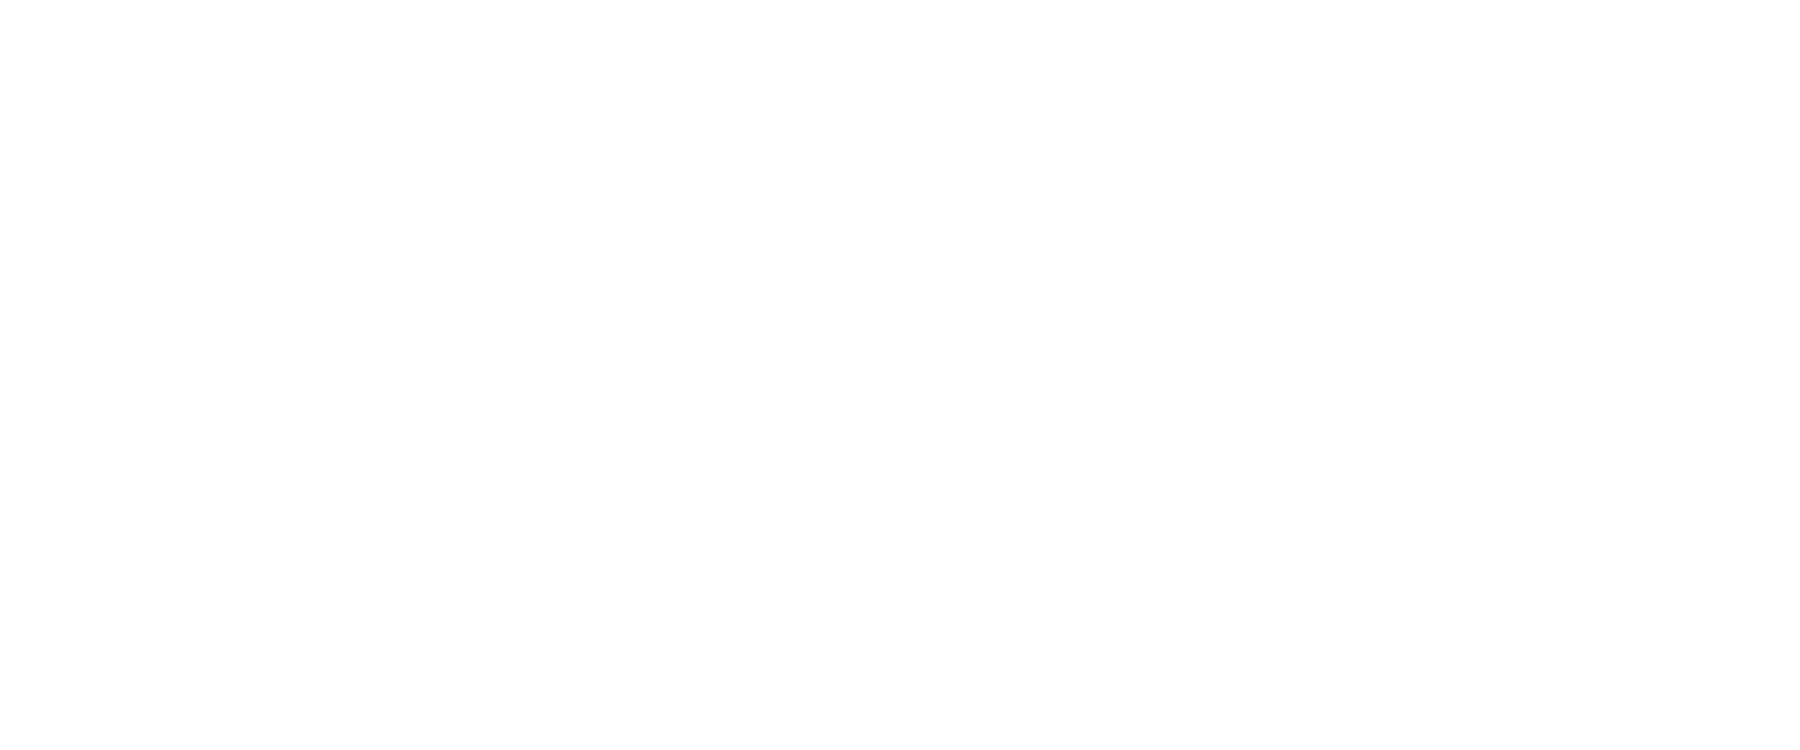

Smoothing the data frame ...


In [59]:
new_frame_path = os.path.join(base_dir, 'yellow_tripdata_2015-01.csv')
jan_2015_df = data_preparation(new_frame_path, kmeans, 2015, 'January')
jan_2015_df.to_csv('./data/ts_data_jan_2015.csv', index=False)

Currently processing :  February_2015 


Number of initial pickup records =  12450521
Initial number of records:12450521
After removing some invalid records the number of records:12361937
Number of initial pickup records =  12450521
Number of outlier coordinates lying outside NY boundaries: 262741
Number of outliers from trip times analysis: 8403
Number of outliers from trip distance analysis: 12916
Number of outliers from speed analysis: 9635
Number of outliers from fare analysis: 113
Total outliers removed 382205
fraction of data points that remain after removing all outliers 0.9693020878403402
Estimating clusters ...
Adding pickup bins ...
Zero filling the data frame ...
pickup_cluster    int64
pickup_bins       int64
count             int64
dtype: object


<IPython.core.display.Javascript object>


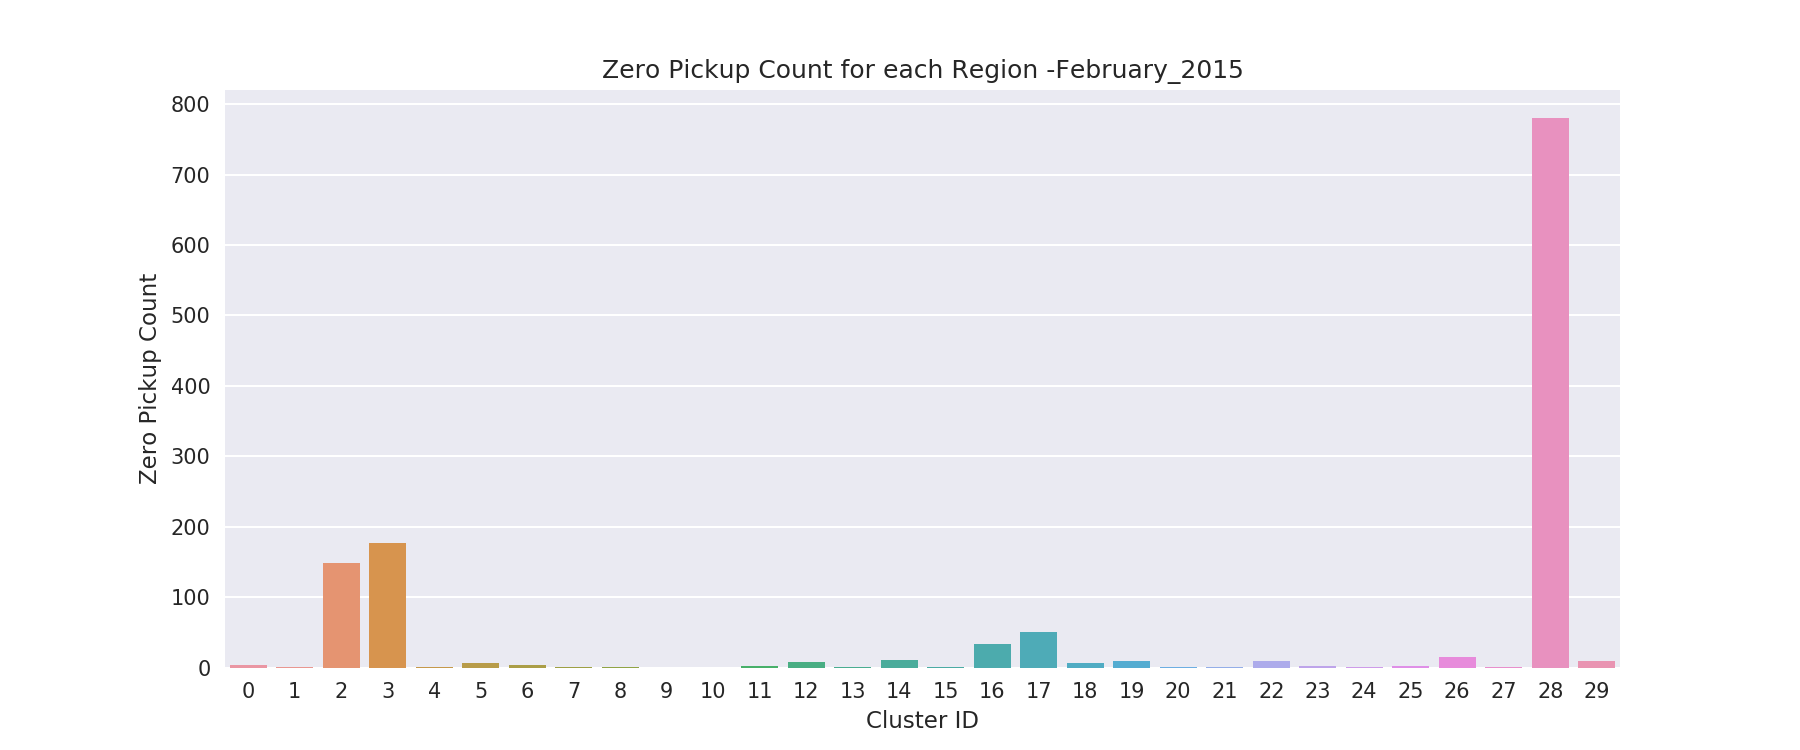

Smoothing the data frame ...


In [60]:
new_frame_path = os.path.join(base_dir, 'yellow_tripdata_2015-02.csv')
feb_2015_df = data_preparation(new_frame_path, kmeans, 2015, 'February')
feb_2015_df.to_csv('./data/ts_data_feb_2015.csv', index=False)

Currently processing :  March_2015 


Number of initial pickup records =  13351609
Initial number of records:13351609
After removing some invalid records the number of records:13251867
Number of initial pickup records =  13351609
Number of outlier coordinates lying outside NY boundaries: 270220
Number of outliers from trip times analysis: 9210
Number of outliers from trip distance analysis: 15805
Number of outliers from speed analysis: 10783
Number of outliers from fare analysis: 162
Total outliers removed 404008
fraction of data points that remain after removing all outliers 0.9697408754255761
Estimating clusters ...
Adding pickup bins ...
Zero filling the data frame ...
pickup_cluster    int64
pickup_bins       int64
count             int64
dtype: object


<IPython.core.display.Javascript object>


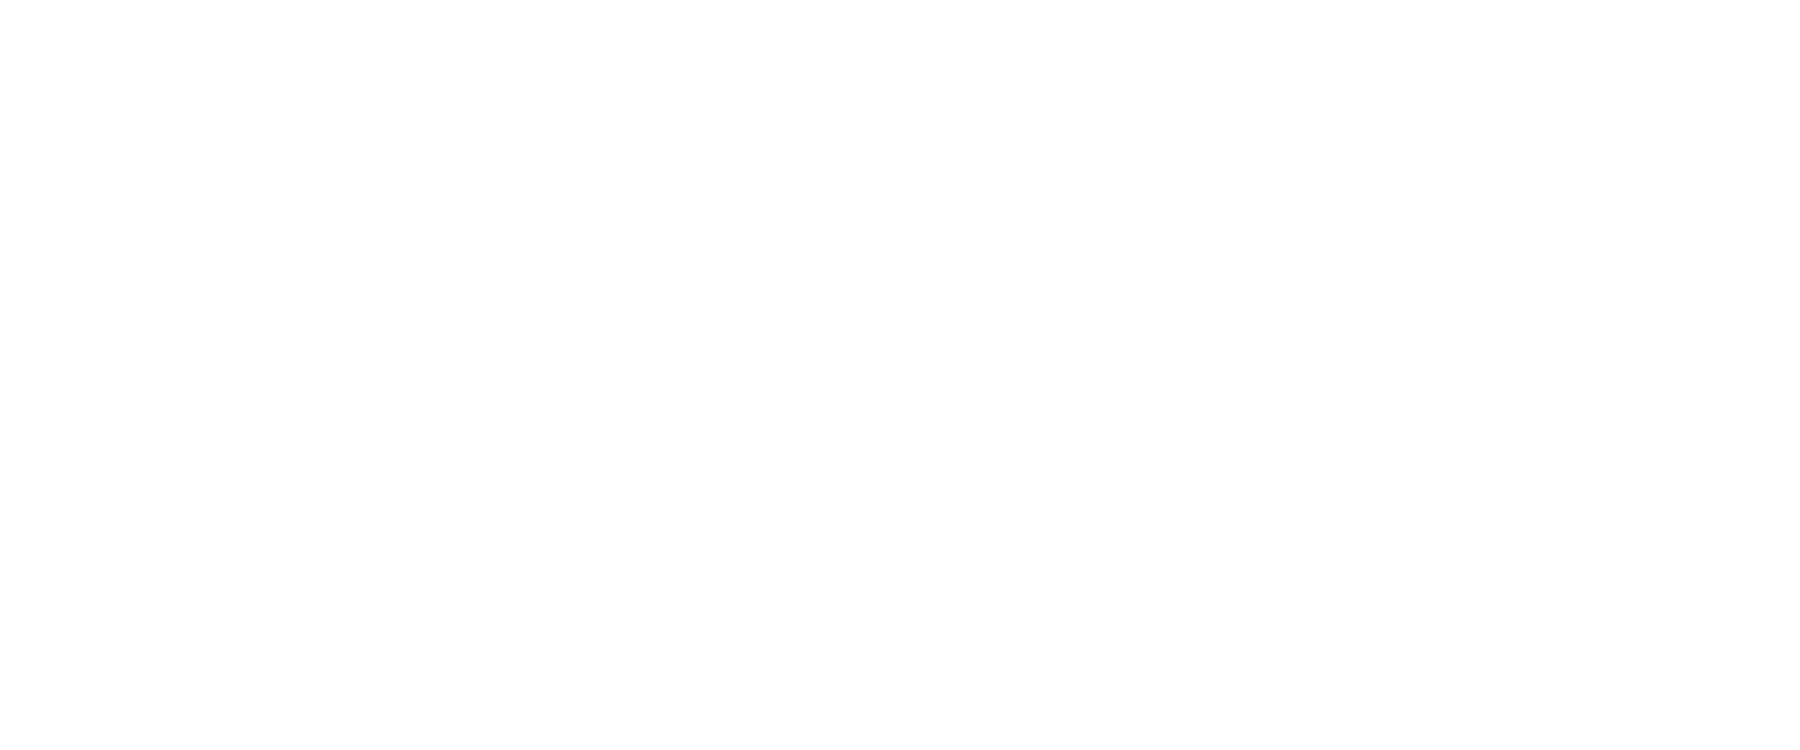

Smoothing the data frame ...


In [61]:
new_frame_path = os.path.join(base_dir,'yellow_tripdata_2015-03.csv')
mar_2015_df = data_preparation(new_frame_path, kmeans, 2015, 'March')
mar_2015_df.to_csv('./data/ts_data_mar_2015.csv', index=False)

Currently processing :  January_2016 


Number of initial pickup records =  10906858
Initial number of records:10906858
After removing some invalid records the number of records:10838806
Number of initial pickup records =  10906858
Number of outlier coordinates lying outside NY boundaries: 189204
Number of outliers from trip times analysis: 15844
Number of outliers from trip distance analysis: 15433
Number of outliers from speed analysis: 9463
Number of outliers from fare analysis: 136
Total outliers removed 298062
fraction of data points that remain after removing all outliers 0.972672056425416
Estimating clusters ...
Adding pickup bins ...
Zero filling the data frame ...
pickup_cluster    int64
pickup_bins       int64
count             int64
dtype: object


<IPython.core.display.Javascript object>


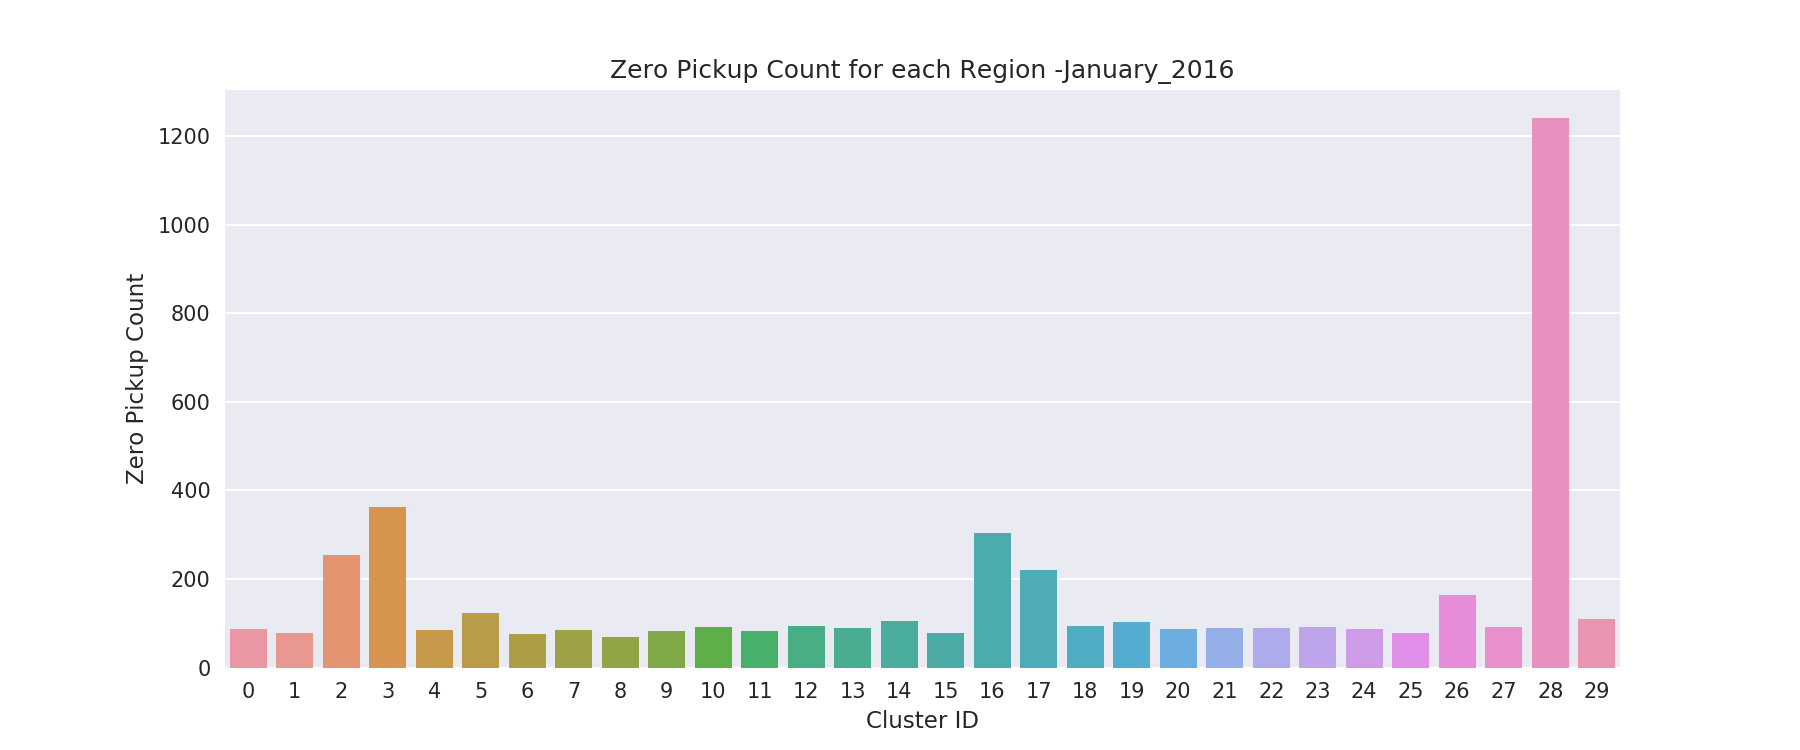

In [62]:
new_frame_path = os.path.join(base_dir,'yellow_tripdata_2016-01.csv')
jan_2016_df = data_preparation(new_frame_path, kmeans, 2016, 'January')
jan_2016_df.to_csv('./data/ts_data_jan_2016.csv', index=False)

Currently processing :  February_2016 


Number of initial pickup records =  11382049
Initial number of records:11382049
After removing some invalid records the number of records:11310334
Number of initial pickup records =  11382049
Number of outlier coordinates lying outside NY boundaries: 197142
Number of outliers from trip times analysis: 15254
Number of outliers from trip distance analysis: 14205
Number of outliers from speed analysis: 9936
Number of outliers from fare analysis: 167
Total outliers removed 308075
fraction of data points that remain after removing all outliers 0.9729332565691818
Estimating clusters ...
Adding pickup bins ...
Zero filling the data frame ...
pickup_cluster    int64
pickup_bins       int64
count             int64
dtype: object


<IPython.core.display.Javascript object>


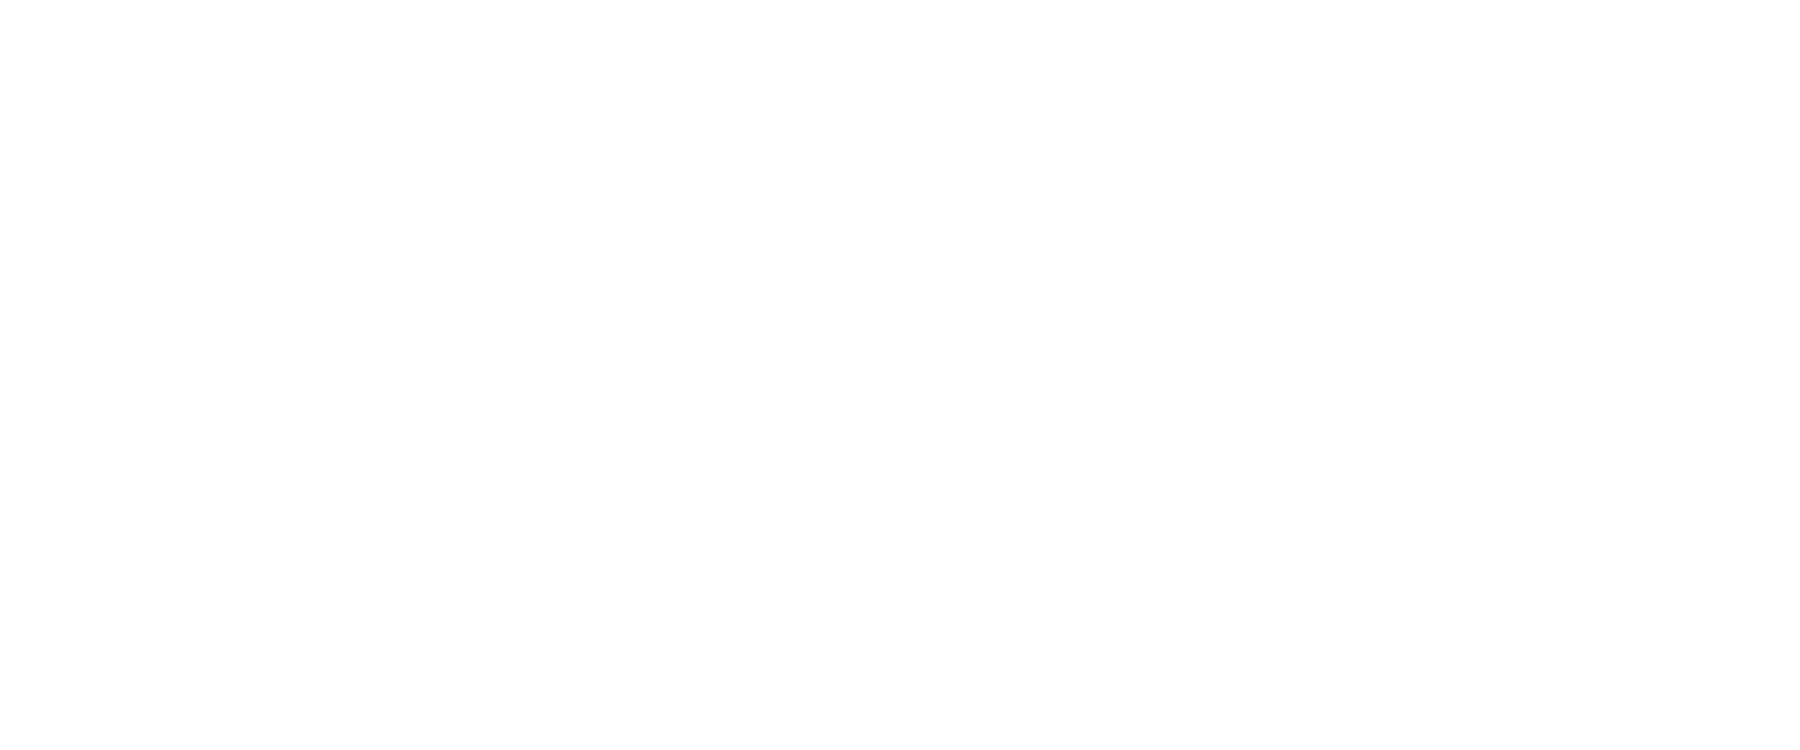

In [63]:
new_frame_path = os.path.join(base_dir,'yellow_tripdata_2016-02.csv')
feb_2016_df = data_preparation(new_frame_path, kmeans, 2016, 'February')
feb_2016_df.to_csv('./data/ts_data_feb_2016.csv', index=False)

Currently processing :  March_2016 


Number of initial pickup records =  12210952
Initial number of records:12210952
After removing some invalid records the number of records:12135823
Number of initial pickup records =  12210952
Number of outlier coordinates lying outside NY boundaries: 205332
Number of outliers from trip times analysis: 18380
Number of outliers from trip distance analysis: 16002
Number of outliers from speed analysis: 11295
Number of outliers from fare analysis: 130
Total outliers removed 324747
fraction of data points that remain after removing all outliers 0.9734052676646342
Estimating clusters ...
Adding pickup bins ...
Zero filling the data frame ...
pickup_cluster    int64
pickup_bins       int64
count             int64
dtype: object


<IPython.core.display.Javascript object>


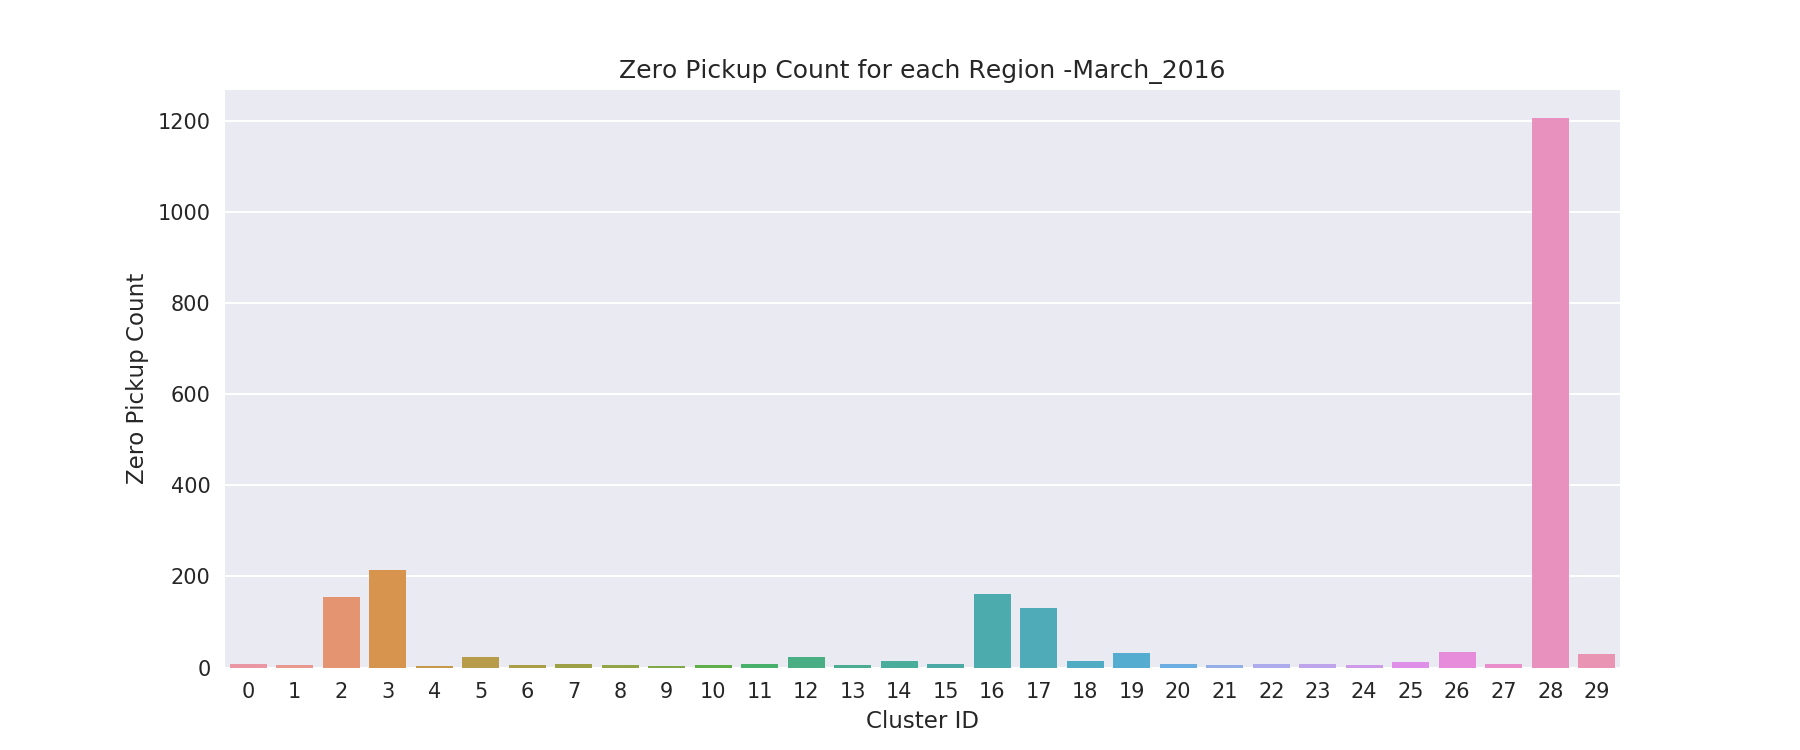

In [64]:
new_frame_path = os.path.join(base_dir,'yellow_tripdata_2016-03.csv')
mar_2016_df = data_preparation(new_frame_path, kmeans, 2016, 'March')
mar_2016_df.to_csv('./data/ts_data_mar_2016.csv', index=False)

In [65]:
print(datetime.now(), ' Done !!!')

2019-06-28 06:10:52.508899  Done !!!


# Procedure Summary

<ul>
<li> EDA is done on the raw data to get some insight about data such as outliers and distribution </li>
<li> Data cleaning is done based on the EDA results </li>
<li> Some data records are dropped based on the abnormal value found for its respecive fields such as 
     distance, speed, fare, trip duation etc. </li>
<li> K-means Clustering of the pickups is done inorder to partition the entire New York 
     into multiple pickup regions </li>
<li> Pickups data after clustering is divided into time bins of 1o mins duration.
<li> Smooting is done on 2015 data & zero filling is done for 2016 data </li>
</ul>

# Conclusion

<ul>
<li> Data set (2015 & 2016 : Jan, Feb, March) is preapared for ML Moldel building </li>
<li> Each data set is 30 x 12960 in dimension (30 regions & 12960 time bins) </li>
<li> The above dataset can be formated/restructured  furher to feed into ML model </li>
</ul>